In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import csv
import re
import string
import nltk
from nltk import FreqDist
import gensim
from gensim import corpora
from nltk.tokenize import MWETokenizer # multi-word expression
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.ticker as ticker
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
import html
import requests
from gensim import corpora, models, similarities, matutils
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift
from sklearn.decomposition import PCA
from pprint import pprint
# import distance methods
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances


# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']
from sklearn.preprocessing import StandardScaler


# uses custom metis style sheet for notebooks
from IPython.core.display import HTML
HTML("""<link rel="stylesheet" href="https://soph.info/metis/nb.css" type="text/css"/>""")
from sklearn.manifold import TSNE


from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle

# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
import pyLDAvis
import pyLDAvis.gensim
#nltk.download('punkt')

Populating the interactive namespace from numpy and matplotlib


In [2]:
#nltk.download('stopwords')

In [3]:
#!pip install Unidecode

In [4]:
df = pd.read_csv("drugsComTrain_raw.tsv",sep='\t')
df2 = pd.read_csv("drugsComTest_raw.tsv",sep='\t')
frames = [df, df2]

In [5]:
new_df = pd.concat(frames)

In [6]:
new_df.to_pickle("./dummy.pkl")

In [7]:
new_df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [8]:
condition_test = new_df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

In [9]:
condition_test.head(20)

condition
Not Listed / Othe                             253
Pain                                          219
Birth Control                                 181
High Blood Pressure                           146
Acne                                          127
Depression                                    115
Rheumatoid Arthritis                          107
Diabetes, Type 2                               97
Allergic Rhinitis                              95
Insomnia                                       85
Osteoarthritis                                 84
Bipolar Disorde                                82
Anxiety                                        81
Abnormal Uterine Bleeding                      77
Endometriosis                                  64
3</span> users found this comment helpful.     62
Psoriasis                                      61
Migraine                                       60
ADHD                                           58
4</span> users found this comment helpfu

In [10]:
new_df.drop(columns=['Unnamed: 0'])

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...
53761,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,13-Sep-14,43
53762,Escitalopram,Anxiety,"""I've been taking Lexapro (escitaploprgram) si...",9.0,8-Oct-16,11
53763,Levonorgestrel,Birth Control,"""I'm married, 34 years old and I have no kids....",8.0,15-Nov-10,7
53764,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,28-Nov-11,20


In [11]:
new_df = shuffle(new_df)

In [12]:
new_df['word_count'] = new_df['review'].apply(lambda x: len(str(x).split(" ")))

In [15]:
new_df.review = new_df.review.apply(html.unescape)

In [16]:
new_df.review

59242     "My daughter was 6 when she started it and her...
29346     "I have been on Lryica for 2 1/2 weeks now. I ...
104578    "TriNessa was the first birth control I had ev...
100375    "Having been diagnosed with Fibromyalgia & nig...
141880    "Took severe pain away. Hand and neck arthriti...
                                ...                        
80099     "This is the best thing that ever happened to ...
121279    "I was just prescribed lidocaine 5% patches by...
16588     "My partner has suffered from severe facial ec...
44346     "Five months ago my total cholesterol was 281 ...
115145    "I have been on belviq for a month now- no cha...
Name: review, Length: 215063, dtype: object

In [1]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

new_df['review'] = new_df.review.map(alphanumeric).map(punc)

In [19]:
new_df.tail()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,word_count
80099,222921,Topamax,Migraine Prevention,this is the best thing that ever happened to m...,10.0,"January 15, 2010",9,129
121279,22716,Lidocaine,Pain,i was just prescribed lidocaine patches by m...,1.0,"February 4, 2017",12,95
16588,8076,EpiCeram,Dry Skin,my partner has suffered from severe facial ecz...,10.0,"February 14, 2013",39,88
44346,10950,Welchol,High Cholesterol,five months ago my total cholesterol was ldl...,9.0,"September 25, 2013",56,87
115145,4552,Belviq,Weight Loss,i have been on belviq for a month now no chang...,1.0,"March 31, 2016",23,58


In [20]:
# There are 215,063 reviews in the dataset
len(new_df)

215063

In [21]:
smaller_df = new_df[:20000]

In [22]:
#max and min word count for reviews
smaller_df['word_count'].describe()

count    20000.000000
mean        85.710800
std         45.051805
min          1.000000
25%         49.000000
50%         85.000000
75%        128.000000
max       1107.000000
Name: word_count, dtype: float64

In [23]:
#avg rating of drug is ~ 7
rating_avg = smaller_df.rating.mean()
rating_avg

7.004

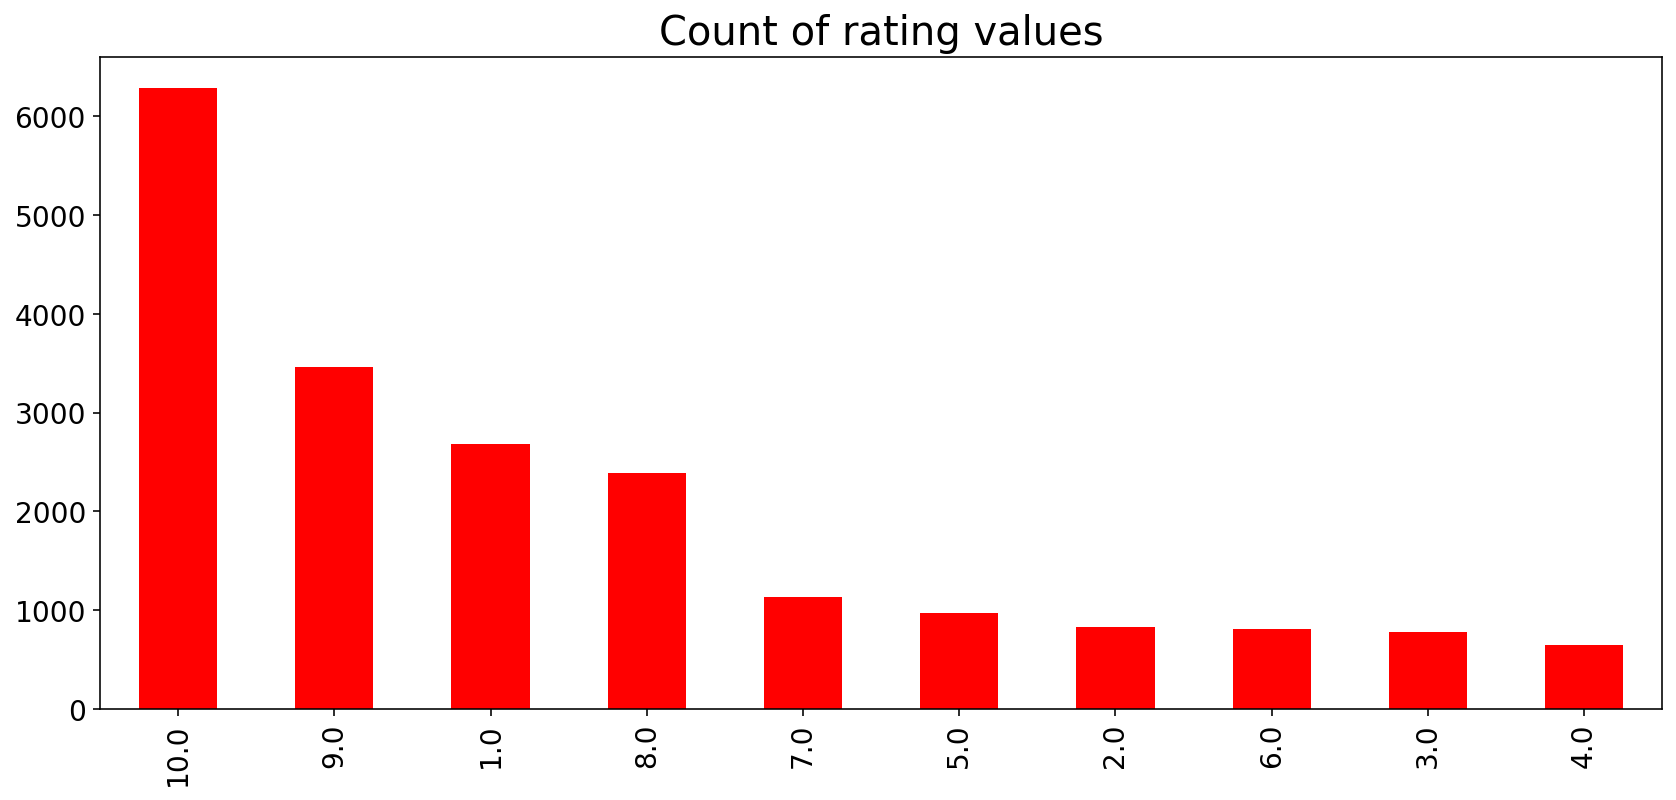

In [424]:
#plot distribution of ratings
rating = smaller_df['rating'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (14,6), fontsize = 14,color='red')
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Count of rating values", fontsize = 20)
plt.savefig('ratings.svg', transparent=True, bbox_inches='tight')

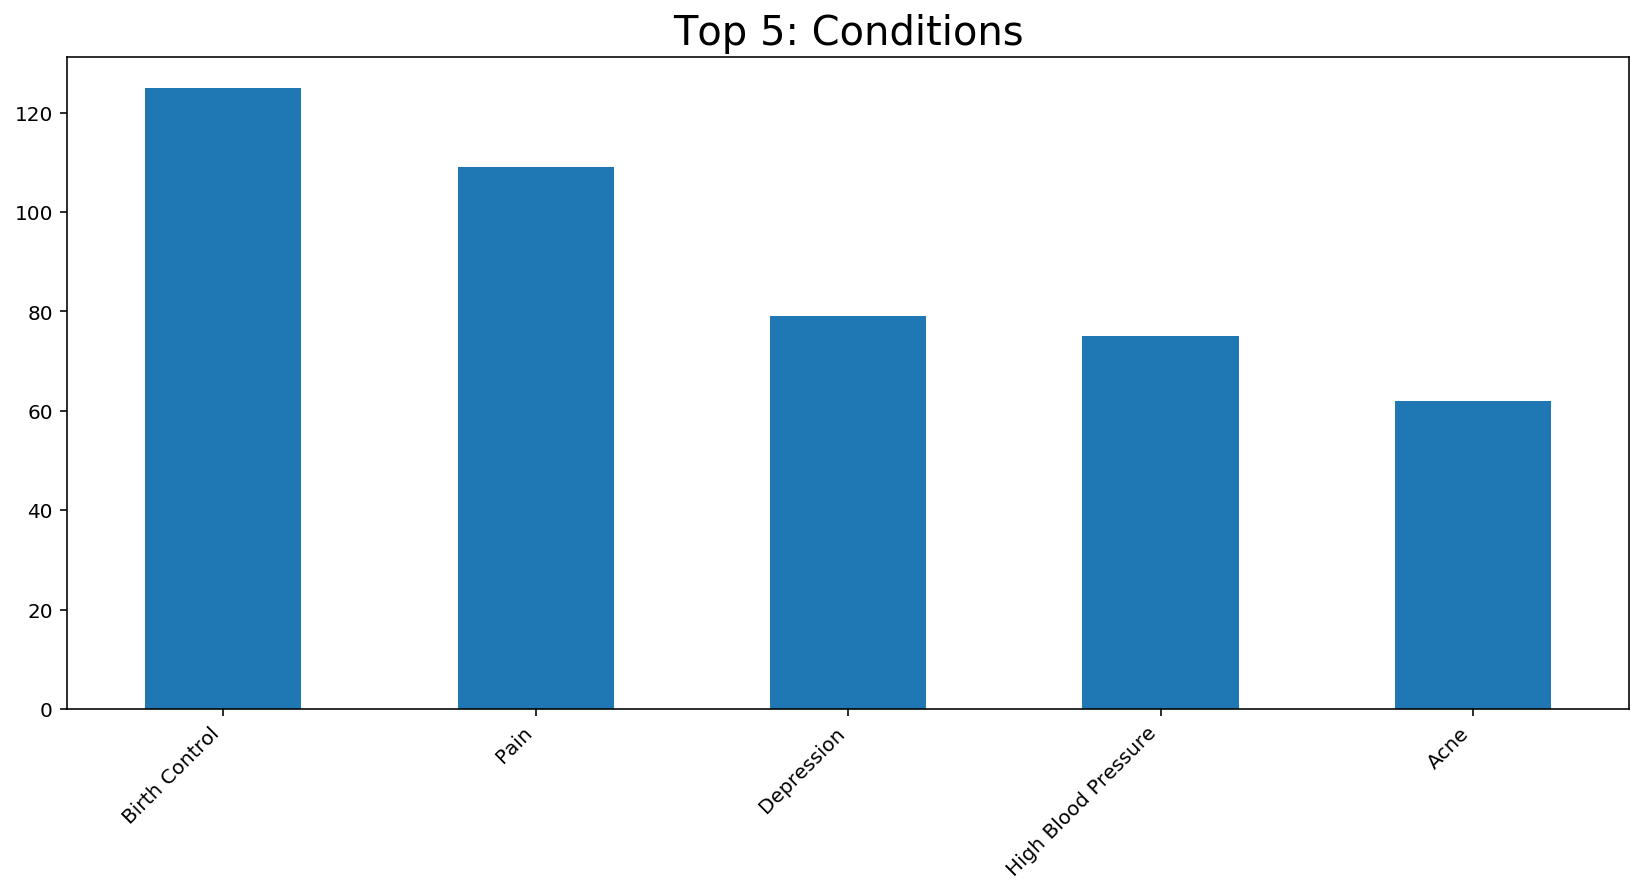

In [312]:
condition_dn = smaller_df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:5].plot(kind="bar", figsize = (14,6), fontsize = 10)
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.xticks(rotation=45, ha='right')
plt.title("Top 5: Conditions", fontsize = 20)
plt.savefig('top_conditions.svg', transparent=True, bbox_inches='tight')

In [27]:
#unique prescription drug counts 3,671
smaller_df.drugName.nunique()

1956

In [28]:
#unique conditions counts 916
smaller_df.condition.nunique()

578

In [29]:
smaller_df.review.head(50)

59242     my daughter was   when she started it and her ...
29346     i have been on lryica for      weeks now i tak...
104578    trinessa was the first birth control i had eve...
100375    having been diagnosed with fibromyalgia  night...
141880    took severe pain away hand and neck arthritis ...
96033     i am still in tears from my wisdom teeth poppi...
40381     ive taken yasmin for   days the second day i h...
15667     i love xenical it is basically making me scare...
19615                                          tastes great
41831        of this product   x daily reduced my    bp ...
35145     i had used this years ago when i had several d...
78363     i stopped smoking with chantix six months ago ...
39363     just started taking belviq   twice daily  my s...
42626              it worked very well with no side effects
70101     this medicine is great for chronic pain i stro...
66914     the first weeks were a bit difficult i had dia...
70274     i had unprotected sex one hour

In [370]:
#Review count per prescription drug
view1 = smaller_df.groupby('drugName').review.agg('count')

In [376]:
order_df = view1.sort_values(ascending=False)
order_df

drugName
Levonorgestrel                       446
Etonogestrel                         409
Ethinyl estradiol / norethindrone    356
Ethinyl estradiol / norgestimate     248
Nexplanon                            241
                                    ... 
Rogaine                                1
Levorphanol                            1
TobraDex                               1
Desmopressin                           1
Levemir                                1
Name: review, Length: 1956, dtype: int64

In [32]:
smaller_df.shape

(20000, 8)

In [33]:
smaller_df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,word_count
59242,219377,Dexmethylphenidate,ADHD,my daughter was when she started it and her ...,10.0,"July 28, 2015",23,44
29346,91961,Lyrica,ibromyalgia,i have been on lryica for weeks now i tak...,9.0,"July 15, 2014",168,154
104578,158929,TriNessa,Birth Control,trinessa was the first birth control i had eve...,2.0,"September 18, 2017",5,107
100375,220044,Amitriptyline,Pain,having been diagnosed with fibromyalgia night...,9.0,"January 8, 2016",112,129
141880,26954,Ultram,Pain,took severe pain away hand and neck arthritis ...,9.0,"March 24, 2017",31,86


### Data Preprocessing

In [34]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count", palette=("YlGnBu_d"))
    ax.set(ylabel = 'Count')
    plt.xticks(rotation=45)
    plt.show()

<Figure size 432x288 with 0 Axes>

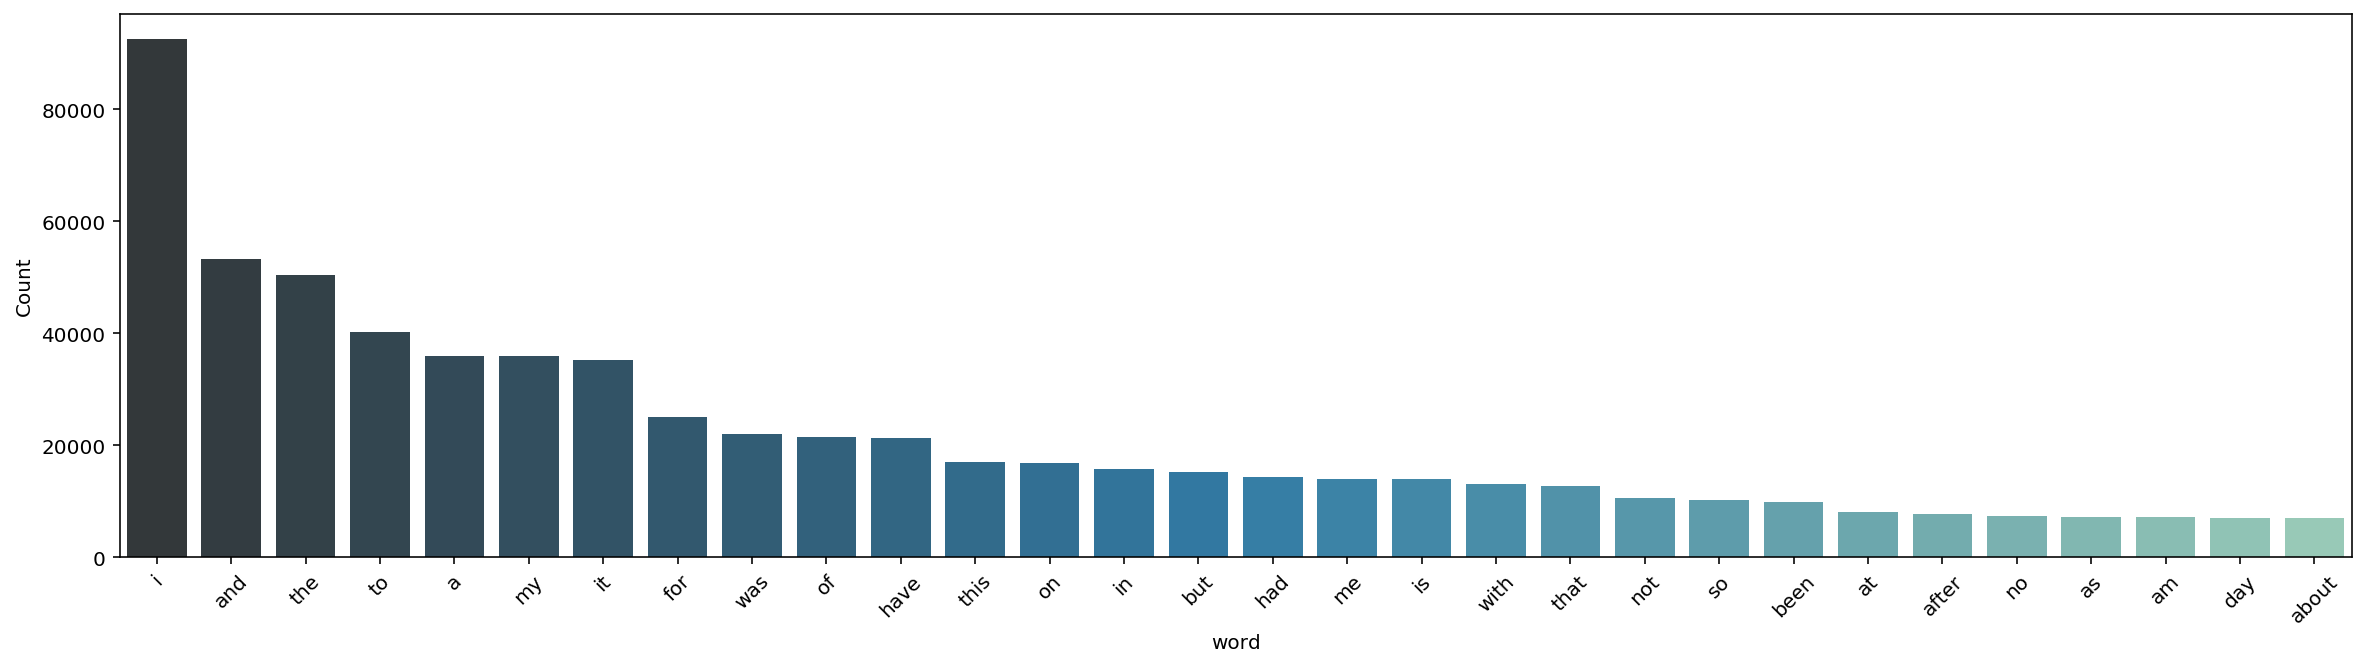

In [35]:
plt.savefig('review1.svg', transparent=True, bbox_inches='tight')
freq_words(smaller_df['review'])

In [36]:
smaller_df['review'].head()

59242     my daughter was   when she started it and her ...
29346     i have been on lryica for      weeks now i tak...
104578    trinessa was the first birth control i had eve...
100375    having been diagnosed with fibromyalgia  night...
141880    took severe pain away hand and neck arthritis ...
Name: review, dtype: object

In [37]:
stop_words = stopwords.words('english')
#stop_words_2 = ['nuvaring','prozac','lot','benadryl','loranzapam','amitiza','zepatier', 'prepopik','daytrana','latuda','trulicity', 'vaniqa','nexplanon', 'prozac','dapsone','ciorofloxacin','deplin', 'intuniv', 'abilify','day', 'oxycontin']
stop_words_3 = ['day','month','week','time','hour', 'last','year','years', 'doctor', 'get','took', 'also', 'got', 'medication','well','first','old','work',
                'since', 'still', 'really', 'went', 'much', 'lot','symptom', 'due', 'many', 'able', 'normal']
stop_words.extend(stop_words_3)

In [38]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
smaller_df['review'] = smaller_df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# # make entire text lowercase
# reviews = [r.lower() for r in reviews]

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in smaller_df['review']]


/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [39]:
#reviews

<Figure size 432x288 with 0 Axes>

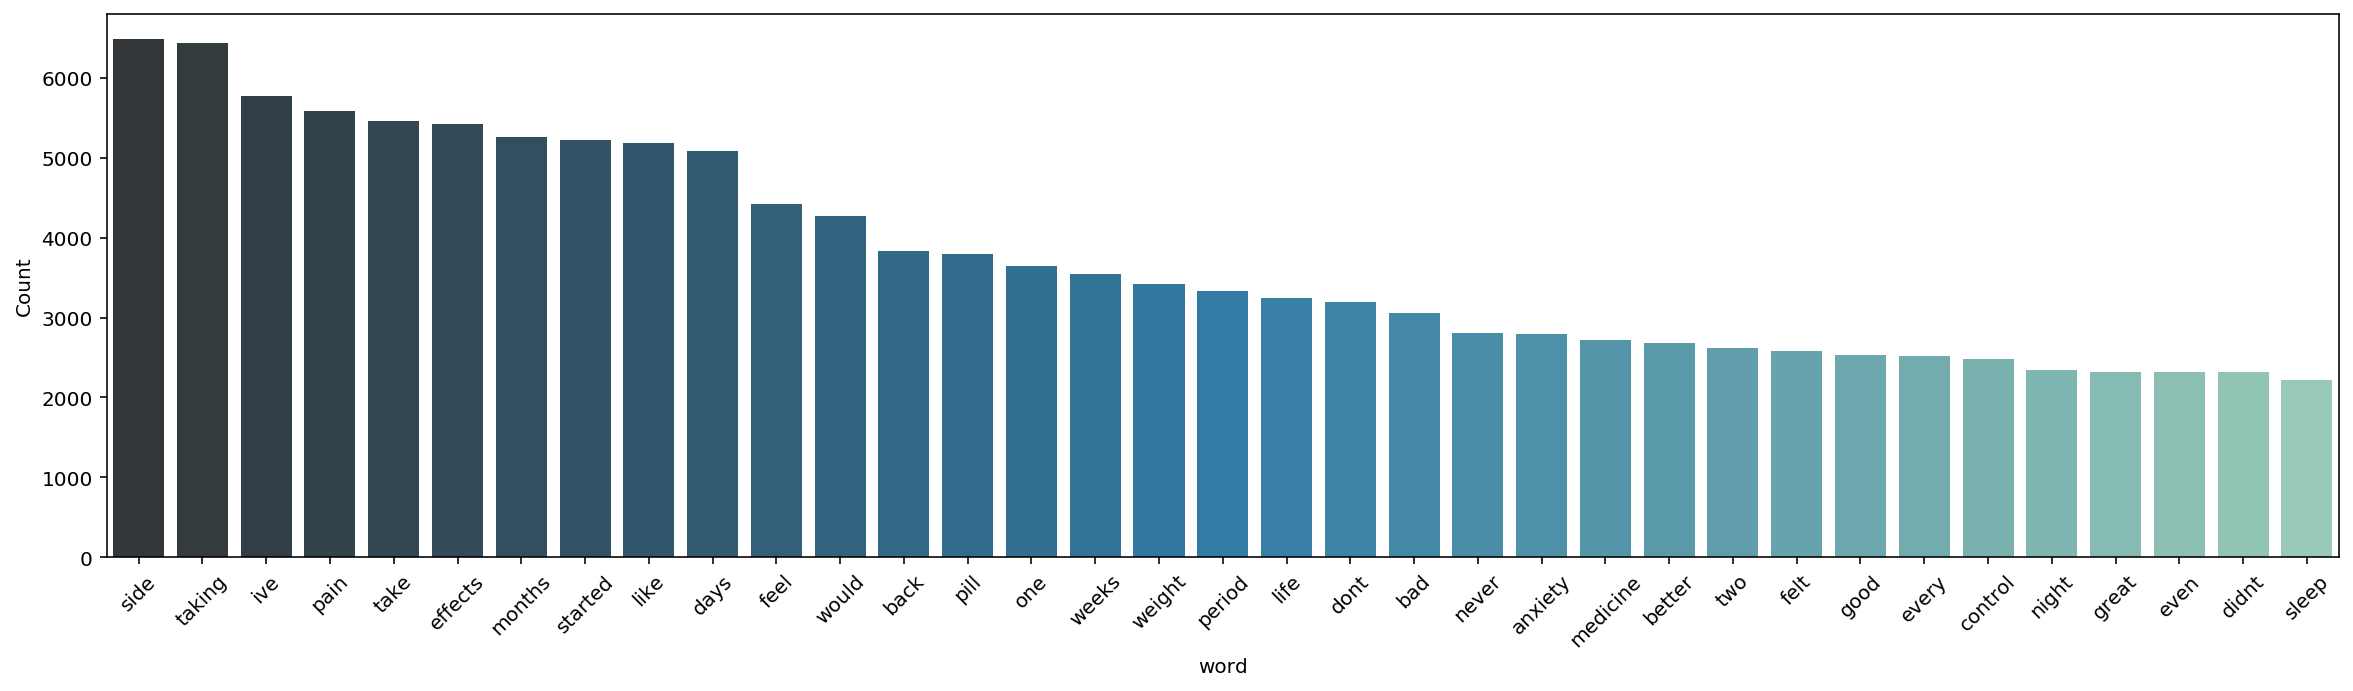

In [40]:
plt.savefig('reviews2', transparent=True, bbox_inches='tight')
freq_words(reviews, 35)

In [41]:
#!pip install spacy

In [42]:
#!python -m spacy download en

In [43]:
import spacy

nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [44]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews)

0        [daughter, started, school, improved, dramatic...
1        [lryica, weeks, take, capsule, morning, night,...
2        [trinessa, birth, control, ever, almost, stop,...
3        [diagnosed, fibromyalgia, night, terrors, ago,...
4        [severe, pain, away, hand, neck, arthritis, ta...
                               ...                        
19995    [carbamazepine, days, could, stand, longer, fe...
19996    [severe, muscle, spasms, pain, shoulder, acdf,...
19997    [used, lyrica, experienced, amazingly, profoun...
19998    [struggling, hot, flashes, severe, total, hyst...
19999    [made, previous, post, right, started, aviane,...
Length: 20000, dtype: object


In [45]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_reviews, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_reviews], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [46]:
# make bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

data_words_bigrams = make_bigrams(tokenized_reviews)

# make trigrams
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_trigrams = make_trigrams(tokenized_reviews)

In [47]:
reviews_2 = lemmatization(data_words_bigrams)
#print(reviews_2) # print lemmatized review

/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<Figure size 432x288 with 0 Axes>

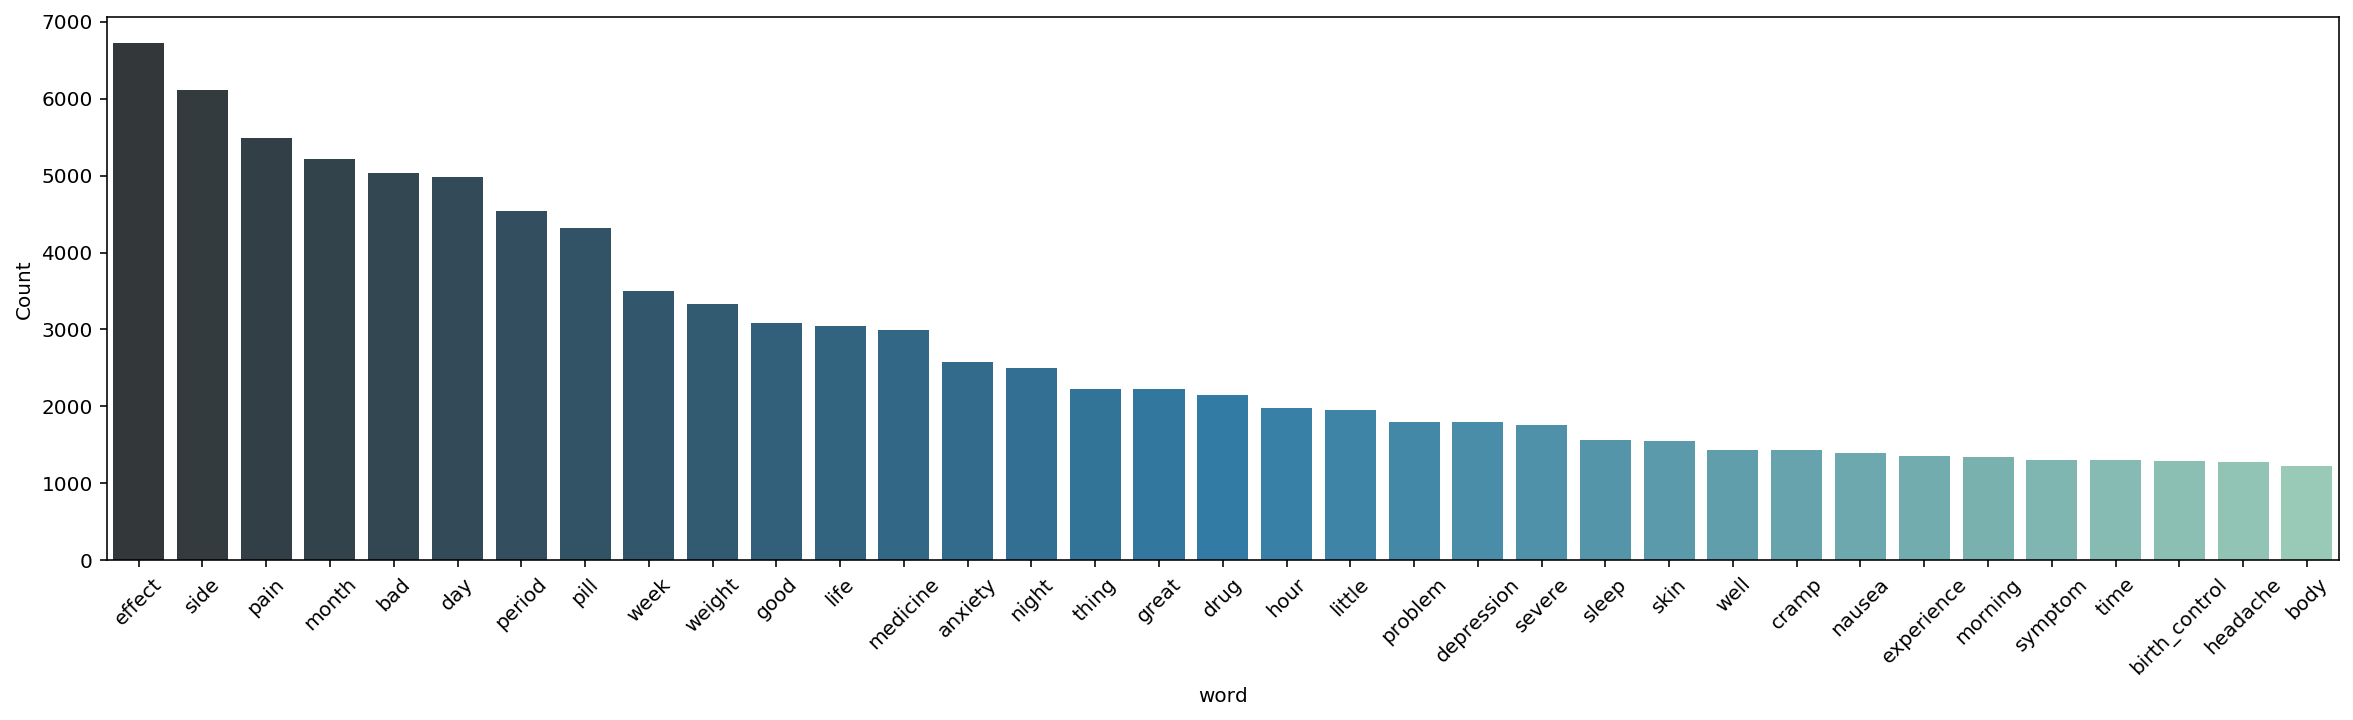

In [48]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

smaller_df['review'] = reviews_3

plt.savefig('reviews3', transparent=True, bbox_inches='tight')
freq_words(smaller_df['review'], 35)

In [ ]:
#reviews_3[0]

In [ ]:
#!pip install pyldavis

### LDA

In [49]:
dictionary = corpora.Dictionary(reviews_2)

In [50]:
dictionary

In [2]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [52]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=15, random_state=100,
                chunksize=100, passes=2)

In [53]:
lda_model.print_topics()

[(0,
  '0.143*"life" + 0.116*"anxiety" + 0.087*"depression" + 0.051*"week" + 0.046*"month" + 0.046*"great" + 0.031*"couple" + 0.029*"mood" + 0.028*"medication" + 0.022*"good"'),
 (1,
  '0.230*"drug" + 0.228*"hour" + 0.064*"sex" + 0.038*"hungry" + 0.033*"plan" + 0.026*"cough" + 0.026*"husband" + 0.024*"sugar" + 0.021*"late" + 0.020*"take"'),
 (2,
  '0.156*"weight" + 0.090*"skin" + 0.076*"month" + 0.068*"pound" + 0.058*"gain" + 0.041*"product" + 0.035*"face" + 0.034*"result" + 0.032*"clear" + 0.027*"change"'),
 (3,
  '0.077*"migraine" + 0.046*"review" + 0.042*"love" + 0.040*"surgery" + 0.037*"other" + 0.036*"one" + 0.034*"negative" + 0.033*"issue" + 0.032*"improvement" + 0.028*"regular"'),
 (4,
  '0.127*"night" + 0.085*"sleep" + 0.058*"morning" + 0.055*"help" + 0.033*"thought" + 0.028*"prescription" + 0.026*"well" + 0.023*"chronic" + 0.023*"start" + 0.022*"overall"'),
 (5,
  '0.385*"effect" + 0.356*"side" + 0.034*"level" + 0.020*"test" + 0.018*"minor" + 0.016*"condition" + 0.015*"friend"

### Model Perplexity & Coherence Score

In [54]:
# # Compute Perplexity - 
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_2, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#Perplexity:  -12.05341222509611

#Coherence Score:  0.359055978534711


Perplexity:  -12.05341222509611

Coherence Score:  0.359055978534711


In [55]:
# #coherence score
for value in range(2,20,2):
    lda_model2 = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=value, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=2,
                                           alpha='auto',
                                           per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_2, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print("Topics: ", value, "Coherence Score: ", coherence_lda)
    
# Topics:  2 Coherence Score:  0.422621932570302
# Topics:  4 Coherence Score:  0.40721549095505916
# Topics:  6 Coherence Score:  0.39266757536982694
# Topics:  8 Coherence Score:  0.44824380215131876

Topics:  2 Coherence Score:  0.34312663485312717
Topics:  4 Coherence Score:  0.40660956768636913
Topics:  6 Coherence Score:  0.4282664916770355
Topics:  8 Coherence Score:  0.39653124472757706
Topics:  10 Coherence Score:  0.4350341168670668
Topics:  12 Coherence Score:  0.43391211786193223
Topics:  14 Coherence Score:  0.40004179172732485
Topics:  16 Coherence Score:  0.3777949067445577
Topics:  18 Coherence Score:  0.39272854013773056


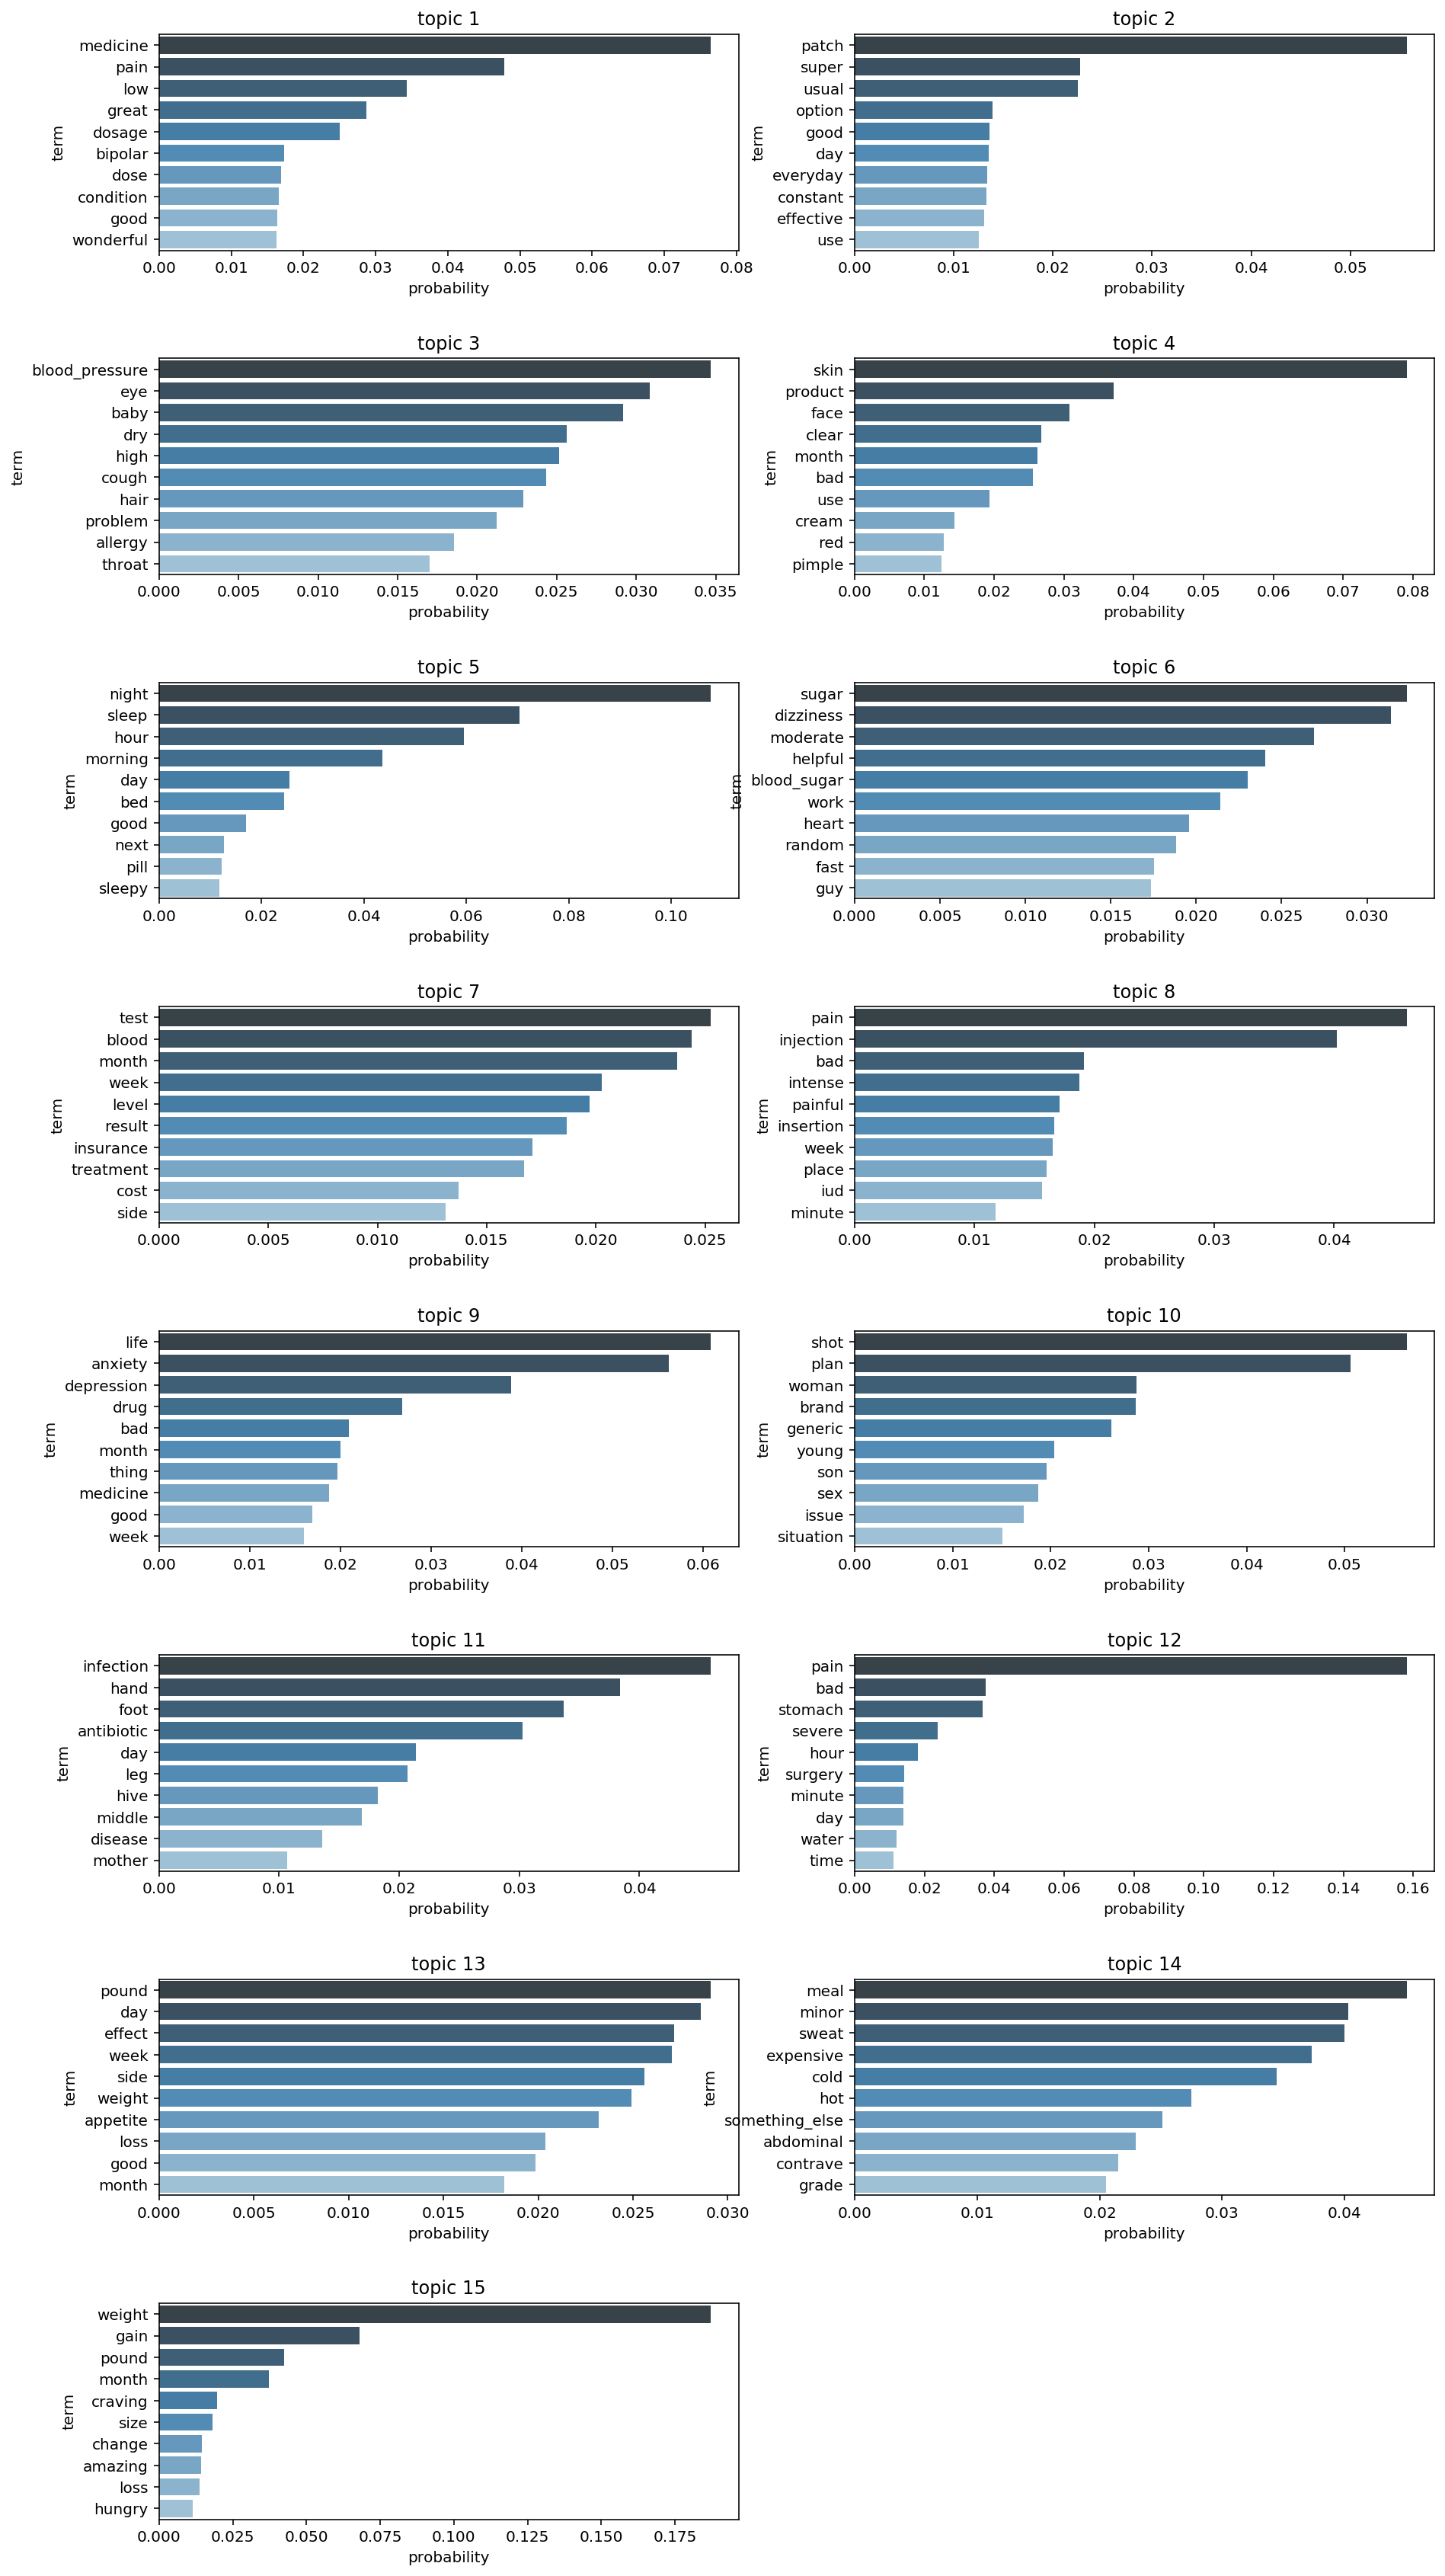

In [56]:
fiz=plt.figure(figsize=(15,30))
for i in range(15):
    df=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')
#     df=df.sort_values('prob')
    
    plt.subplot(8,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='Blues_d')
    plt.xlabel('probability')
    plt.subplots_adjust(hspace=.5)

plt.savefig('mulitple_topics.svg', transparent=True, bbox_inches='tight')
plt.show()

In [57]:
#Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.save_html(vis, 'lda.html')
vis

/anaconda3/envs/metis/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [58]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/carissasosa/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=15, id2word=dictionary)

In [59]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=reviews_2, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(10,
  [('night', 0.11882459226855595),
   ('sleep', 0.07417621606200371),
   ('hour', 0.06775712044125339),
   ('morning', 0.06357282107365318),
   ('tired', 0.03556654462460178),
   ('bed', 0.03100185440540155),
   ('work', 0.027293043602301365),
   ('bit', 0.01735533260425087),
   ('tablet', 0.017307783747800867),
   ('hard', 0.015928866910750798)]),
 (9,
  [('bad', 0.11688752973156642),
   ('nausea', 0.06742391146060871),
   ('headache', 0.06198728217076841),
   ('migraine', 0.05397796223484297),
   ('severe', 0.043784282316392406),
   ('horrible', 0.03786223969710208),
   ('terrible', 0.02854230377166157),
   ('symptom', 0.0254356584631814),
   ('extreme', 0.02509586913256638),
   ('sick', 0.024610455803116355)]),
 (7,
  [('good', 0.12271000625090157),
   ('bad', 0.09962975429148435),
   ('thing', 0.08986873106698082),
   ('experience', 0.0405346925037265),
   ('people', 0.030292830696735107),
   ('shot', 0.020483723613982787),
   ('bit', 0.020291388180987642),
   ('part', 0.0182

In [60]:
#find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [61]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=reviews_2, start=2, limit=40, step=6)

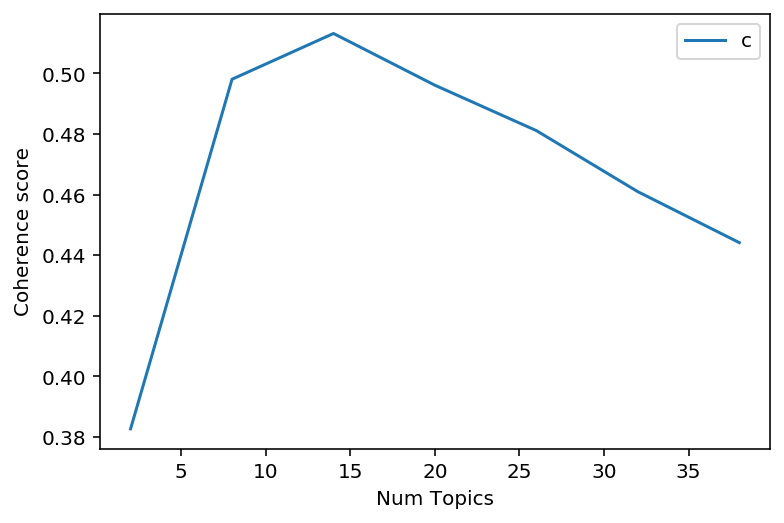

In [62]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('best#topics.svg', transparent=True, bbox_inches='tight')
plt.show()

In [63]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3827
Num Topics = 8  has Coherence Value of 0.4981
Num Topics = 14  has Coherence Value of 0.5132
Num Topics = 20  has Coherence Value of 0.4961
Num Topics = 26  has Coherence Value of 0.4811
Num Topics = 32  has Coherence Value of 0.461
Num Topics = 38  has Coherence Value of 0.4441


In [64]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.161*"week" + 0.097*"great" + 0.049*"low" + 0.028*"body" + 0.026*"couple" '
  '+ 0.024*"level" + 0.023*"daily" + 0.022*"difference" + 0.020*"bit" + '
  '0.020*"med"'),
 (1,
  '0.219*"day" + 0.062*"nausea" + 0.060*"bad" + 0.057*"headache" + '
  '0.050*"migraine" + 0.039*"symptom" + 0.030*"horrible" + 0.027*"sick" + '
  '0.023*"extreme" + 0.021*"nauseous"'),
 (2,
  '0.110*"night" + 0.069*"sleep" + 0.068*"hour" + 0.059*"morning" + '
  '0.033*"tired" + 0.029*"bed" + 0.023*"dose" + 0.018*"work" + 0.016*"tablet" '
  '+ 0.015*"dosage"'),
 (3,
  '0.042*"stomach" + 0.040*"minute" + 0.028*"water" + 0.021*"today" + '
  '0.020*"dose" + 0.019*"hour" + 0.018*"constipation" + 0.017*"diarrhea" + '
  '0.016*"easy" + 0.015*"hard"'),
 (4,
  '0.138*"bad" + 0.122*"good" + 0.099*"thing" + 0.053*"experience" + '
  '0.045*"people" + 0.026*"review" + 0.020*"job" + 0.020*"positive" + '
  '0.019*"negative" + 0.017*"part"'),
 (5,
  '0.068*"skin" + 0.031*"product" + 0.027*"treatment" + 0.026*"clear" + '
 

In [148]:
final_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [149]:
#Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(final_model, doc_term_matrix, dictionary)
pyLDAvis.save_html(vis, 'lda.html')
vis

/anaconda3/envs/metis/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/envs/metis/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/envs/metis/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/envs/metis/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9     -0.111509  0.181544       1        1  7.419232
8      0.048878  0.051528       2        1  7.324640
11     0.177356 -0.026997       3        1  7.199431
5     -0.038784  0.207530       4        1  7.170703
3      0.009371  0.085183       5        1  7.154387
7     -0.104402  0.213986       6        1  7.135981
2      0.211301  0.030157       7        1  7.129802
4     -0.162014 -0.221665       8        1  7.127491
10    -0.269852  0.001108       9        1  7.099501
13     0.080586 -0.105599      10        1  7.075776
1     -0.181701 -0.232013      11        1  7.070546
12     0.090650 -0.012840      12        1  7.057955
0      0.053208 -0.079945      13        1  7.018916
6      0.196912 -0.091977      14        1  7.015639, topic_info=    Category         Freq       Term        Total  loglift  logprob
1    Default  7224.000000     effect  7224.000000  30.0000  30.0000
5    Default  6565.000000       side  6565.000000  29.0000  29.0000
24   Default  5776.000000       pain  5776.000000  28.0000  28.0000
82   Default  5362.000000        day  5362.000000  27.0000  27.0000
74   Default  4634.000000       pill  4634.000000  26.0000  26.0000
..       ...          ...        ...          ...      ...      ...
450  Topic14   199.193551    control   476.198812   1.7855  -4.7850
728  Topic14   151.817788    patient   222.866656   2.2731  -5.0566
659  Topic14   160.431563  wonderful   332.812609   1.9273  -5.0014
339  Topic14   158.278119       stop   332.099710   1.9159  -5.0149
857  Topic14   151.817788       head   457.656691   1.5536  -5.0566

[1115 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5134      3  0.950647       abbot
771       1  0.013307   abdominal
771       3  0.984717   abdominal
4053      1  1.011678    abortion
8151      9  0.931990  abstinence
...     ...       ...         ...
1311      9  1.009656         yaz
1061      5  1.000283   yesterday
7342     11  0.927983     yohimbe
606      10  0.957339       young
606      11  0.047867       young

[1374 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 12, 6, 4, 8, 3, 5, 11, 14, 2, 13, 1, 7])

In [65]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = optimal_model[doc_term_matrix]
lda_corpus

[[(0, 0.06265664160401005),
  (1, 0.06265664160401005),
  (2, 0.08020050125313283),
  (3, 0.06265664160401005),
  (4, 0.06265664160401005),
  (5, 0.06265664160401005),
  (6, 0.06265664160401005),
  (7, 0.11528822055137845),
  (8, 0.06265664160401005),
  (9, 0.06265664160401005),
  (10, 0.06265664160401005),
  (11, 0.06265664160401005),
  (12, 0.09774436090225563),
  (13, 0.08020050125313283)],
 [(0, 0.09639953542392568),
  (1, 0.04626403406891213),
  (2, 0.07336430507162214),
  (3, 0.07065427797135114),
  (4, 0.05574912891986062),
  (5, 0.04490902051877663),
  (6, 0.07471931862175765),
  (7, 0.07878435927216415),
  (8, 0.06794425087108014),
  (9, 0.04626403406891213),
  (10, 0.04490902051877663),
  (11, 0.17092528068137827),
  (12, 0.06929926442121563),
  (13, 0.05981416957026713)],
 [(0, 0.05252100840336136),
  (1, 0.05905695611577965),
  (2, 0.054154995331465935),
  (3, 0.06722689075630253),
  (4, 0.05252100840336136),
  (5, 0.08356676003734827),
  (6, 0.07212885154061624),
  (7, 0.0

In [66]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]
lda_docs[0]

[(0, 0.06265664160401005),
 (1, 0.06265664160401005),
 (2, 0.08020050125313283),
 (3, 0.06265664160401005),
 (4, 0.06265664160401005),
 (5, 0.06265664160401005),
 (6, 0.06265664160401005),
 (7, 0.11528822055137845),
 (8, 0.06265664160401005),
 (9, 0.06265664160401005),
 (10, 0.06265664160401005),
 (11, 0.06265664160401005),
 (12, 0.09774436090225563),
 (13, 0.08020050125313283)]

In [67]:
lda_docs2 = [doc for doc in lda_corpus]

In [68]:
lda_docs2

[[(0, 0.06265664160401005),
  (1, 0.06265664160401005),
  (2, 0.08020050125313283),
  (3, 0.06265664160401005),
  (4, 0.06265664160401005),
  (5, 0.06265664160401005),
  (6, 0.06265664160401005),
  (7, 0.11528822055137845),
  (8, 0.06265664160401005),
  (9, 0.06265664160401005),
  (10, 0.06265664160401005),
  (11, 0.06265664160401005),
  (12, 0.09774436090225563),
  (13, 0.08020050125313283)],
 [(0, 0.09639953542392568),
  (1, 0.04626403406891213),
  (2, 0.07336430507162214),
  (3, 0.07065427797135114),
  (4, 0.05574912891986062),
  (5, 0.04490902051877663),
  (6, 0.07471931862175765),
  (7, 0.07878435927216415),
  (8, 0.06794425087108014),
  (9, 0.04626403406891213),
  (10, 0.04490902051877663),
  (11, 0.17092528068137827),
  (12, 0.06929926442121563),
  (13, 0.05981416957026713)],
 [(0, 0.05252100840336136),
  (1, 0.05905695611577965),
  (2, 0.054154995331465935),
  (3, 0.06722689075630253),
  (4, 0.05252100840336136),
  (5, 0.08356676003734827),
  (6, 0.07212885154061624),
  (7, 0.0

In [70]:
df = pd.DataFrame([[y[1] for y in  x] for x in lda_docs])
print (df)

              0         1         2         3         4         5         6  \
0      0.062657  0.062657  0.080201  0.062657  0.062657  0.062657  0.062657   
1      0.096400  0.046264  0.073364  0.070654  0.055749  0.044909  0.074719   
2      0.052521  0.059057  0.054155  0.067227  0.052521  0.083567  0.072129   
3      0.139854  0.051266  0.097812  0.048263  0.048263  0.069284  0.048263   
4      0.066253  0.066253  0.064642  0.056591  0.074304  0.071084  0.053370   
...         ...       ...       ...       ...       ...       ...       ...   
19995  0.093106  0.121298  0.074864  0.061597  0.053305  0.053305  0.084814   
19996  0.073308  0.046992  0.054302  0.068922  0.046992  0.046992  0.057226   
19997  0.053597  0.063698  0.050711  0.081014  0.106988  0.085343  0.138734   
19998  0.079592  0.051020  0.124036  0.068481  0.078005  0.070068  0.058957   
19999  0.101587  0.048810  0.044643  0.044643  0.094643  0.105754  0.044643   

              7         8         9        10      

In [71]:
np.array(lda_docs).shape

(20000, 14, 2)

In [77]:
df_test = pd.DataFrame([[y[1] for y in  x] for x in lda_docs2])
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.062657,0.062657,0.080201,0.062657,0.062657,0.062657,0.062657,0.115288,0.062657,0.062657,0.062657,0.062657,0.097744,0.080201
1,0.096400,0.046264,0.073364,0.070654,0.055749,0.044909,0.074719,0.078784,0.067944,0.046264,0.044909,0.170925,0.069299,0.059814
2,0.052521,0.059057,0.054155,0.067227,0.052521,0.083567,0.072129,0.067227,0.129318,0.088469,0.068861,0.052521,0.073763,0.078665
3,0.139854,0.051266,0.097812,0.048263,0.048263,0.069284,0.048263,0.072287,0.069284,0.048263,0.055770,0.151866,0.048263,0.051266
4,0.066253,0.066253,0.064642,0.056591,0.074304,0.071084,0.053370,0.059811,0.053370,0.080745,0.067863,0.177364,0.051760,0.056591


In [78]:
df_test['review'] = smaller_df['review'].values

In [107]:
df_test['drugName'] = smaller_df['drugName'].values

In [108]:
df_test['condition'] = smaller_df['condition'].values

In [109]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,review,drugName,condition
0,0.062657,0.062657,0.080201,0.062657,0.062657,0.062657,0.062657,0.115288,0.062657,0.062657,0.062657,0.062657,0.097744,0.080201,daughter school side effect hungry force hungry,Dexmethylphenidate,ADHD
1,0.096400,0.046264,0.073364,0.070654,0.055749,0.044909,0.074719,0.078784,0.067944,0.046264,0.044909,0.170925,0.069299,0.059814,week capsule morning night buttock leg foot pa...,Lyrica,ibromyalgia
2,0.052521,0.059057,0.054155,0.067227,0.052521,0.083567,0.072129,0.067227,0.129318,0.088469,0.068861,0.052521,0.073763,0.078665,anxiety depression period awful easy manageabl...,TriNessa,Birth Control
3,0.139854,0.051266,0.097812,0.048263,0.048263,0.069284,0.048263,0.072287,0.069284,0.048263,0.055770,0.151866,0.048263,0.051266,night_terror maximum amount paracetamol little...,Amitriptyline,Pain
4,0.066253,0.066253,0.064642,0.056591,0.074304,0.071084,0.053370,0.059811,0.053370,0.080745,0.067863,0.177364,0.051760,0.056591,severe pain hand neck arthritis dose good reli...,Ultram,Pain


In [122]:
df_test.shape

(20000, 17)

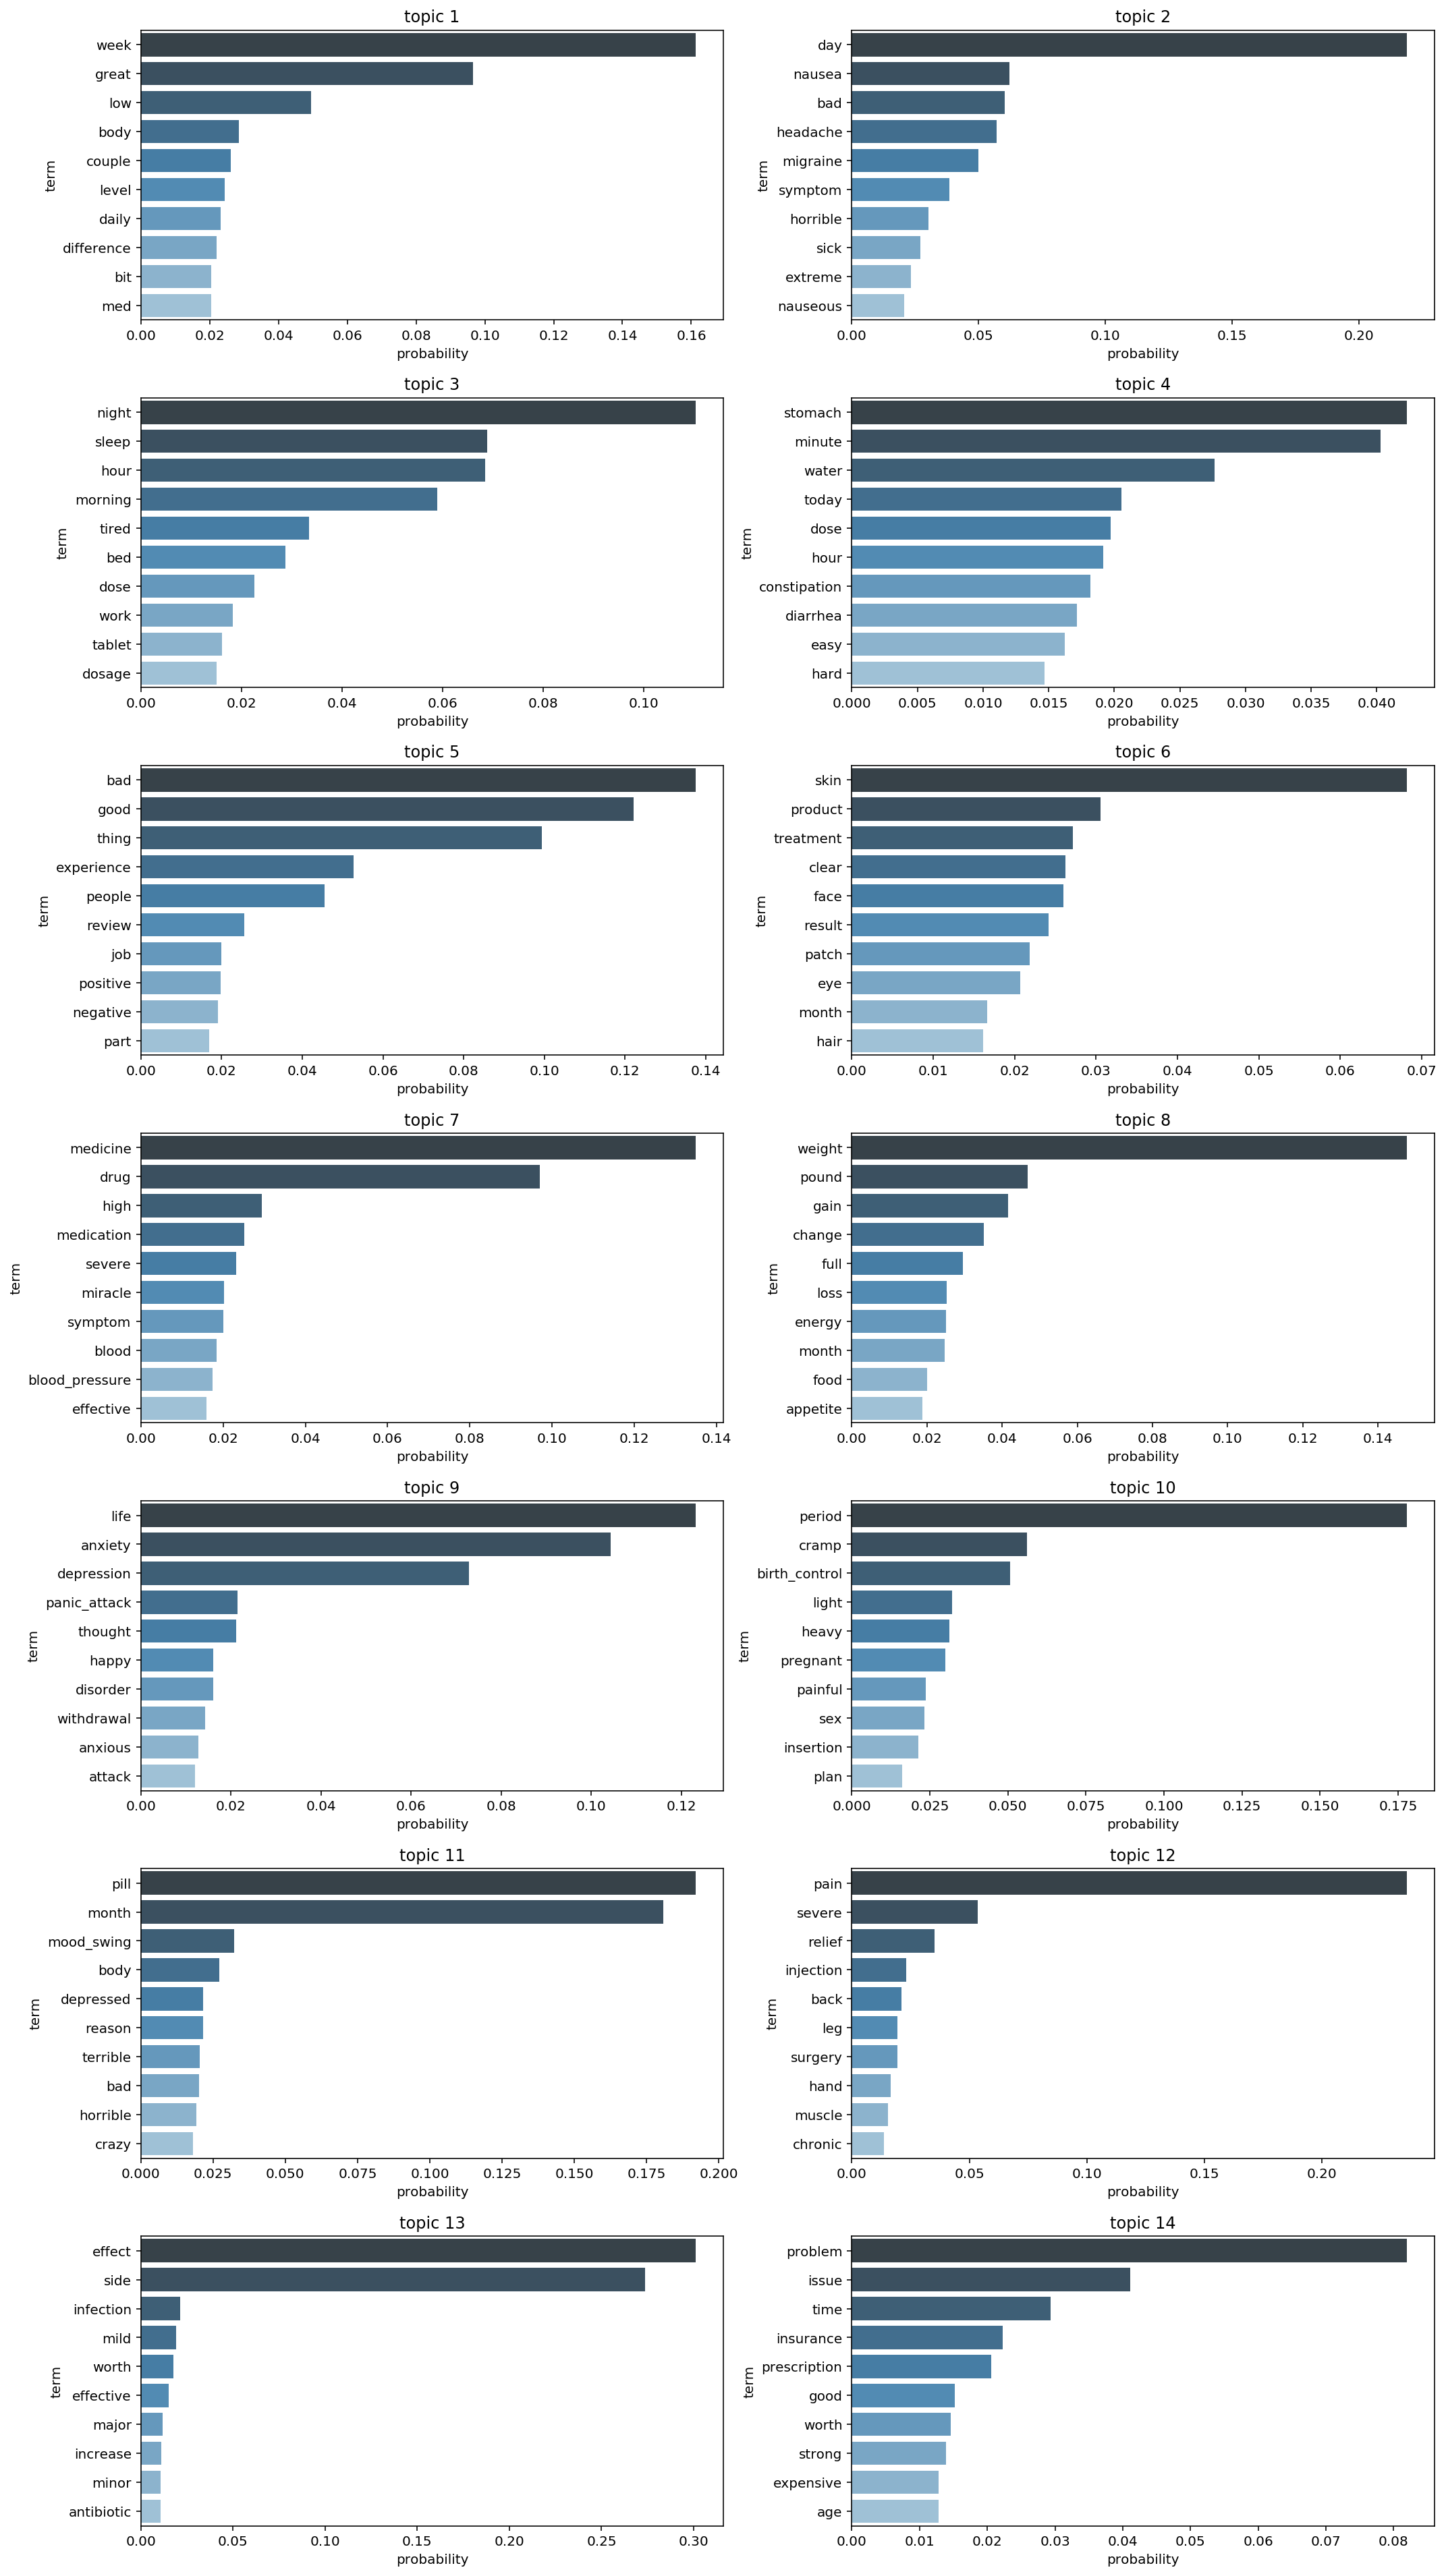

In [80]:
fiz=plt.figure(figsize=(15,30))
for i in range(14):
    df2=pd.DataFrame(optimal_model.show_topic(i), columns=['term','prob']).set_index('term')
#     df=df.sort_values('prob')
    
    plt.subplot(8,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df2.index, data=df2, label='Cities', palette='Blues_d')
    plt.xlabel('probability')
    plt.subplots_adjust(hspace=.5)

plt.savefig('mulitple_topics_optimal_model.svg', transparent=True, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [81]:
def format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=reviews_2):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=doc_term_matrix, texts=reviews_2)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.shape

(20000, 5)

In [82]:
df_dominant_topic['drugName'] = smaller_df['drugName'].values

In [83]:
df_dominant_topic['condition']= smaller_df['condition'].values

In [360]:
df_dominant_topic.tail(30)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,drugName,condition
19970,19970,6.0,0.1513,"medicine, drug, high, medication, severe, mira...","[people, medicine, helpful, treating, episode,...",Haloperidol,Mania
19971,19971,8.0,0.1242,"life, anxiety, depression, panic_attack, thoug...","[writing_review, sleepless, night, review, med...",Effexor,Major Depressive Disorde
19972,19972,11.0,0.1537,"pain, severe, relief, injection, back, leg, su...","[pain, formulation, breakthrough, pain, typica...",Nucynta,Pain
19973,19973,11.0,0.2367,"pain, severe, relief, injection, back, leg, su...","[bilateral, arthritis, disk, location, drug, m...",Buprenorphine,Pain
19974,19974,5.0,0.1051,"skin, product, treatment, clear, face, result,...","[right, application, average, application]",Clobetasol,Dermatitis
19975,19975,5.0,0.1902,"skin, product, treatment, clear, face, result,...","[strength, pore, blackhead, small, pustule, cy...",Tazorac,Acne
19976,19976,9.0,0.0961,"period, cramp, birth_control, light, heavy, pr...","[terrible, different, person, tired, bloated, ...",Ethinyl estradiol / levonorgestrel,Endometriosis
19977,19977,2.0,0.0995,"night, sleep, hour, morning, tired, bed, dose,...","[month, well, medicine, focus, stuff, stick, t...",Vyvanse,ADHD
19978,19978,8.0,0.1279,"life, anxiety, depression, panic_attack, thoug...","[birth, difference, day, swing, period, bad, t...",Duloxetine,Anxiety
19979,19979,8.0,0.1416,"life, anxiety, depression, panic_attack, thoug...","[quetiapine, approx, month, anxiety, tablet, b...",Quetiapine,Generalized Anxiety Disorde


In [191]:
#view3 = df_dominant_topic.groupby(['drugName'])['condition'].nunique().sort_values(ascending=False)

In [192]:
#view3

### Recommendation System

In [97]:
cosine_sim = cosine_similarity(df_test.iloc[:,0:14], df_test.iloc[:,0:14])
print(cosine_sim)

[[1.         0.89610095 0.93694451 ... 0.87868805 0.94407549 0.89412001]
 [0.89610095 1.         0.84899397 ... 0.82292471 0.89980161 0.80089639]
 [0.93694451 0.84899397 1.         ... 0.93072756 0.89422895 0.89992057]
 ...
 [0.87868805 0.82292471 0.93072756 ... 1.         0.86532399 0.85069099]
 [0.94407549 0.89980161 0.89422895 ... 0.86532399 1.         0.91065065]
 [0.89412001 0.80089639 0.89992057 ... 0.85069099 0.91065065 1.        ]]


In [123]:
cosine_sim.shape

(20000, 20000)

In [110]:
indices = pd.Series(df_test['drugName'])

In [111]:
indices

0                        Dexmethylphenidate
1                                    Lyrica
2                                  TriNessa
3                             Amitriptyline
4                                    Ultram
                        ...                
19995                         Carbamazepine
19996                         Methocarbamol
19997                                Lyrica
19998                             Melatonin
19999    Ethinyl estradiol / levonorgestrel
Name: drugName, Length: 20000, dtype: object

In [397]:
def recommend(drugName, cosine_sim = cosine_sim):
    recommended_drugs = []
    idx = indices[indices == drugName].index[0]
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top_10_indices = list(score_series.iloc[1:11].index)
    
    for i in top_10_indices:
            recommended_drugs.append(list(df_test['drugName'])[i]) 

            
    return recommended_drugs

In [425]:
recommend('Mirena')

['Levitra',
 'Yaz',
 'Medroxyprogesterone',
 'Geodon',
 'Escitalopram',
 'Mirena',
 'Clomid',
 'Levonorgestrel',
 'Rapaflo',
 'Oxybutynin']

In [281]:
select_topic = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == 9]
select_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,drugName,condition
28,28,9.0,0.1830,"period, cramp, birth_control, light, heavy, pr...","[different, contraceptive, pill, month, heavy,...",Medroxyprogesterone,Birth Control
36,36,9.0,0.1610,"period, cramp, birth_control, light, heavy, pr...","[nuvaring, month, implant, hormone, irregular,...",NuvaRing,Birth Control
55,55,9.0,0.1387,"period, cramp, birth_control, light, heavy, pr...","[polycystic, ovary, couple, couple, period, te...",Spironolactone,Acne
61,61,9.0,0.1250,"period, cramp, birth_control, light, heavy, pr...","[month, amazing, child, insertion, painful, al...",Levonorgestrel,Birth Control
78,78,9.0,0.1576,"period, cramp, birth_control, light, heavy, pr...","[arm, period, day, hair, horrible, cramp, bad,...",Ethinyl estradiol / levonorgestrel,Birth Control
...,...,...,...,...,...,...,...
19949,19949,9.0,0.2358,"period, cramp, birth_control, light, heavy, pr...","[child, birth_control, irregular, period, mont...",Mirena,Abnormal Uterine Bleeding
19969,19969,9.0,0.2238,"period, cramp, birth_control, light, heavy, pr...","[month, insertion, point, help, obnoxious, per...",Levonorgestrel,Birth Control
19976,19976,9.0,0.0961,"period, cramp, birth_control, light, heavy, pr...","[terrible, different, person, tired, bloated, ...",Ethinyl estradiol / levonorgestrel,Endometriosis
19981,19981,9.0,0.1440,"period, cramp, birth_control, light, heavy, pr...","[pco, long, difficult, period, implantation, i...",Etonogestrel,Birth Control


In [432]:
select_drug = df_dominant_topic.loc[df_dominant_topic.drugName == 'Oxybutynin']
select_drug

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,drugName,condition
2071,2071,2.0,0.1033,"night, sleep, hour, morning, tired, bed, dose,...","[overactive_bladder, incontinence, bad, single...",Oxybutynin,Urinary Incontinence
3936,3936,5.0,0.1113,"skin, product, treatment, clear, face, result,...","[life, deal, overactive_bladder, point, bad, n...",Oxybutynin,Overactive Bladde
4037,4037,13.0,0.1021,"problem, issue, time, insurance, prescription,...","[oxybutynin, happy, result, antibiotic, proble...",Oxybutynin,Overactive Bladde
4363,4363,13.0,0.1532,"problem, issue, time, insurance, prescription,...","[walmart, stock, pharmacy, product, luck, phar...",Oxybutynin,Overactive Bladde
4684,4684,3.0,0.1195,"stomach, minute, water, today, dose, hour, con...","[oxybutynin, pee, minute, approx, hour]",Oxybutynin,Overactive Bladde
5388,5388,5.0,0.1479,"skin, product, treatment, clear, face, result,...","[female, age, hyperhidrosis, age, hereditary, ...",Oxybutynin,Hyperhidrosis
7270,7270,5.0,0.0863,"skin, product, treatment, clear, face, result,...","[patch, complete, waste_money]",Oxybutynin,Overactive Bladde
7448,7448,5.0,0.1561,"skin, product, treatment, clear, face, result,...","[medicine, great, overactive_bladder, irritati...",Oxybutynin,Overactive Bladde
8306,8306,12.0,0.0980,"effect, side, infection, mild, worth, effectiv...","[daily, oxybutynin, side, effect, least, bladd...",Oxybutynin,Overactive Bladde
8462,8462,3.0,0.1114,"stomach, minute, water, today, dose, hour, con...","[oxybutin, little, blister, tongue, bladder, m...",Oxybutynin,Overactive Bladde


### LSA

In [193]:
vectorizer = CountVectorizer(stop_words, max_df = .7, ngram_range=(1, 3))
doc_word = vectorizer.fit_transform(smaller_df.review)
doc_word.shape

(20000, 470455)

In [194]:
pd.DataFrame(doc_word.toarray(), index=smaller_df.review, columns=vectorizer.get_feature_names()).head(10)

,aaaaarg,aaahhh,aaahhh bad,aaahhh bad pain,abandonment,abandonment borderline_personality,abandonment borderline_personality disorder,abate,abate action,abate action fearful,...,zyprexa self,zyprexa self happy,zyprexa symptom,zyprexa symptom tolerable,zypreza,zypreza none,zypreza none different,zyrtec,zyrtec week,zyrtec week severe
review,,,,,,,,,,,,,,,,,,,,,
daughter school side effect hungry force hungry,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
week capsule morning night buttock leg foot pain double spinal_fusion nerve pain life medicine pain real side effect high hrs uplifted depression bit aggressive time close check weight fit strong workout pain,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
anxiety depression period awful easy manageable skin clear anxiety depression panic_attack mood_swing multiple time pound birth_control similar worth,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
night_terror maximum amount paracetamol little relief chronic pain sleep amazing pain level life morning fine amazing feeling daily fit painmuscle spasm pain level diary real help,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
severe pain hand neck arthritis dose good relief hrs pain well vicodin sure happy con occasional nausea big pill period week,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
prescribed medicine pain,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
day second calf pain right leg next night calf pain good acne,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
love scared rubbish oily poo side effect urgent need food different way family size chocolate bar minute attitude food healthy food unhealthy food disgusted unhealthy fat body artery heart visual education healthy weight thank xenical,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
great,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [195]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
lsa = TruncatedSVD(25)#principle components,shorten it 
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_#% out of 100% how much of first new engineered features gives

#around 8% for new information from 20 of the new features

array([0.01426989, 0.01434029, 0.01159254, 0.00738667, 0.00665234,
       0.00613011, 0.00577162, 0.00511335, 0.00502196, 0.00447729,
       0.0041075 , 0.00404258, 0.00365726, 0.00337366, 0.00319342,
       0.0030545 , 0.00259395, 0.00245422, 0.00239423, 0.00233309,
       0.00223498, 0.00222085, 0.00209973, 0.0020685 , 0.00194737])

In [196]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2", "component_3","component_4","component_5","component_6","component_7","component_8","component_9","component_10",
             "component_11","component_12","component_13","component_14","component_15","component_16", "component_17","component_18","component_19","component_20",
                "component_21","component_22","component_23","component_24","component_25"],
             columns = vectorizer.get_feature_names())

['component_' + str(i) for i in range(1,26)]

topic_word
#meta level, represent component higher than themselves

,aaaaarg,aaahhh,aaahhh bad,aaahhh bad pain,abandonment,abandonment borderline_personality,abandonment borderline_personality disorder,abate,abate action,abate action fearful,...,zyprexa self,zyprexa self happy,zyprexa symptom,zyprexa symptom tolerable,zypreza,zypreza none,zypreza none different,zyrtec,zyrtec week,zyrtec week severe
component_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000
component_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000,-0.0,-0.0,...,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.000,-0.000,-0.000
component_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000,-0.000,-0.000
component_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000,-0.000,-0.000
component_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.000,-0.000,-0.000
component_6,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.000,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000,-0.000,-0.000
component_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000,-0.000,-0.000
component_8,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.000,-0.000,-0.000
component_9,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.000,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000,-0.000,-0.000
component_10,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.000,0.000,0.000


In [197]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [198]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
effect, side, side effect, pain, period, month, bad, day, pill, weight

Topic  1
period, pill, pain, month, day, bad, cramp, weight, birth_control, week

Topic  2
pain, medicine, severe, night, hour, relief, life, bad, drug, sleep

Topic  3
anxiety, bad, life, night, medicine, depression, month, drug, good, week

Topic  4
day, bad, night, hour, period, period day, cramp, day day, sleep, nausea

Topic  5
pill, bad, night, hour, good, morning, sleep, pill pill, stomach, birth_control pill

Topic  6
bad, period, cramp, skin, bad side, bad side effect, side, side effect, insertion, birth_control

Topic  7
weight, bad, gain, weight gain, pound, loss, weight loss, day, gain weight, mood_swing

Topic  8
period, anxiety, life, depression, medicine, week, thing, pain, panic_attack, weight

Topic  9
night, sleep, hour, good, period, morning, week, medicine, skin, little

Topic  10
medicine, good, life, period, month, day, migraine, great, thing, problem

Topic  11
medicine, week, skin,

In [199]:
doc_topic

array([[ 1.20480098, -1.15453168, -0.19163144, ...,  0.03612826,
        -0.0139541 ,  0.01567546],
       [ 3.00078993,  0.0249815 ,  3.3932086 , ..., -0.28960493,
         0.4191481 ,  0.09299867],
       [ 0.93447414,  0.65745206, -0.51997295, ..., -0.58889056,
         0.68779241,  0.54147612],
       ...,
       [ 1.55154093,  0.04520331,  0.19061445, ..., -0.10191735,
         0.23749737, -0.10760232],
       [ 0.74737698, -0.26671595,  0.24026805, ..., -0.61988568,
        -0.12237796, -0.56835951],
       [ 1.34975432,  1.2993661 , -0.60454522, ...,  0.14643955,
        -0.20727784,  0.09385499]])

In [200]:
Vt = pd.DataFrame(doc_topic.round(5),
             index = smaller_df.review,
             columns = ["component_1","component_2", "component_3","component_4","component_5","component_6","component_7","component_8","component_9","component_10",
             "component_11","component_12","component_13","component_14","component_15","component_16", "component_17","component_18","component_19","component_20",
             "component_21","component_22","component_23","component_24","component_25"])
Vt

#vectors not same length, cosine similarity, not euclidean distanct between points, how far they are from origin  
#model.components 

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25
review,,,,,,,,,,,,,,,,,,,,,
daughter school side effect hungry force hungry,1.20480,-1.15453,-0.19163,-0.38462,0.00718,0.01928,0.05523,-0.01730,-0.01662,-0.01372,...,-0.06457,-0.02036,0.02944,-0.01578,-0.04829,0.01486,-0.03532,0.03613,-0.01395,0.01568
week capsule morning night buttock leg foot pain double spinal_fusion nerve pain life medicine pain real side effect high hrs uplifted depression bit aggressive time close check weight fit strong workout pain,3.00079,0.02498,3.39321,-0.47446,-0.80089,-0.16908,-0.83791,0.51086,0.91155,0.28705,...,-0.32514,-0.79918,-0.00713,0.09844,-0.18493,0.15677,-0.09576,-0.28960,0.41915,0.09300
anxiety depression period awful easy manageable skin clear anxiety depression panic_attack mood_swing multiple time pound birth_control similar worth,0.93447,0.65745,-0.51997,0.90874,-0.09278,-0.58938,0.01679,-0.56529,1.44382,-0.82382,...,1.10860,-0.03116,-0.30512,0.08913,-0.13763,-0.38154,0.13360,-0.58889,0.68779,0.54148
night_terror maximum amount paracetamol little relief chronic pain sleep amazing pain level life morning fine amazing feeling daily fit painmuscle spasm pain level diary real help,1.20880,0.85159,2.82660,-0.23120,-0.48084,-0.03588,-0.41336,-0.10879,0.50503,0.06919,...,-0.09690,0.11734,0.10533,-0.11389,0.01492,0.32600,-0.68072,0.30463,0.63953,-0.00022
severe pain hand neck arthritis dose good relief hrs pain well vicodin sure happy con occasional nausea big pill period week,1.51611,1.46707,1.34746,-0.68138,-0.32117,0.39660,-0.35051,-0.31539,0.69398,0.18515,...,-0.15643,0.07724,-0.51148,0.28871,0.03199,0.07172,0.47183,-0.19098,-0.16288,-0.90636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
carbamazepine day ill sinus pain runny_nose headache bed feeling flu reading advice leaflet react surprising med free,0.61190,0.48925,0.89455,-0.17437,0.61333,-0.15548,-0.38549,0.06678,-0.35594,-0.24773,...,-0.04164,0.04743,-0.01533,0.22616,0.11942,-0.03824,0.00166,0.09819,-0.04111,-0.06638
severe muscle_spasm pain shoulder operative pain week spasm pain shoulder trapezoidal muscle percocet noticeable side effect additional benefit low back pain decade other side effect worth antiinflammatory,3.66198,-1.29195,3.22371,-1.88169,-0.63969,-0.21770,-0.05021,-0.06467,0.31565,-0.25091,...,-0.12033,-0.22572,-0.08928,0.10028,-0.08958,-0.17267,0.32511,-0.03521,-0.05147,-0.26103
experienced profound reaction layer depression anxiety several minute drug thing bad withdrawal effect dose throw dark pit despair drug performed miracle strong long convince thing bad enough warrant miraculous,1.55154,0.04520,0.19061,1.81805,0.34757,0.17052,1.50719,0.21713,0.66781,-0.52999,...,0.96953,-0.18988,1.52851,0.43098,-0.78639,-0.66378,-0.01992,-0.10192,0.23750,-0.10760


In [ ]:
# ### Create a scree plot to see how many topics to include
# # plt.figure(figsize=(20,12))
# plt.plot(lsa.explained_variance_ratio_, 'mx--')
# plt.xlabel('Number of Topics')
# plt.ylabel('Explained variance');
# plt.title('Elbow Method For Optimal Topics Using Explained Variance');

In [201]:
cum_var_explained = []
prev_tot_var = 0
for i, var in enumerate(lsa.explained_variance_ratio_):
    tot_var = var + prev_tot_var
    cum_var_explained.append(tot_var)
    prev_tot_var = tot_var
    print(var, tot_var)

0.014269887187889518 0.014269887187889518
0.014340286679965782 0.0286101738678553
0.011592539199924179 0.04020271306777948
0.007386665961710304 0.04758937902948978
0.006652335169570895 0.054241714199060674
0.006130109167381257 0.06037182336644193
0.005771617274714574 0.0661434406411565
0.005113347989832358 0.07125678863098886
0.0050219606833352805 0.07627874931432414
0.0044772913466355905 0.08075604066095973
0.004107499607527058 0.08486354026848679
0.0040425837702687635 0.08890612403875556
0.0036572631903600333 0.09256338722911558
0.003373661142512338 0.09593704837162792
0.003193418403014534 0.09913046677464245
0.003054495987224207 0.10218496276186666
0.002593953434385336 0.10477891619625199
0.0024542176954829545 0.10723313389173494
0.0023942340988025194 0.10962736799053746
0.0023330903045989974 0.11196045829513646
0.002234979616375235 0.1141954379115117
0.0022208548054826805 0.11641629271699437
0.002099730190705954 0.11851602290770033
0.002068496014208745 0.12058451892190908
0.0019473

In [ ]:
# plt.plot(cum_var_explained)
# plt.xlabel('Number of Topics')
# plt.ylabel('Cumulative Explained variance');
# plt.title('Scree plot for drugs.com reviews');

In [202]:
cosine_similarity((Vt.iloc[0], Vt.iloc[1]))[0][0].round()

array([[1., 0.],
       [0., 1.]])

In [203]:
cosine_similarity((Vt.iloc[0], Vt.iloc[99])).round()

array([[ 1., -0.],
       [-0.,  1.]])

In [239]:
# cosine_sim2 = cosine_similarity(Vt.iloc[:,0:24], Vt.iloc[:,0:24])
# print(cosine_sim2)

In [240]:
# def recommend(drugName, cosine_sim = cosine_sim2):
#     recommended_drugs = []
#     idx = indices[indices == drugName].index[0]
#     score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
#     top_10_indices = list(score_series.iloc[1:11].index)
    
#     for i in top_10_indices:
#             recommended_drugs.append(list(df_test['drugName'])[i]) 
            
#     return recommended_drugs

In [241]:
# recommend

### PCA on LSA

In [204]:
pca = PCA(n_components=2)
X_std = StandardScaler().fit_transform(doc_topic)
X_transf = pca.fit_transform(X_std)
print("shape of original X_train:", doc_topic.shape)
print("shape of X_train using 2 principal components:", X_transf.shape, "\n")
print(X_transf)

shape of original X_train: (20000, 25)
shape of X_train using 2 principal components: (20000, 2) 

[[ 1.25165665 -0.61653143]
 [ 2.25599927 -0.55722842]
 [-0.44516338  1.1643222 ]
 ...
 [-0.28628912 -0.96903338]
 [-0.36209774 -0.95143514]
 [-0.36939727  1.91163077]]


([<matplotlib.axis.XTick at 0x1a45b935f8>,
 <a list of 2 Text xticklabel objects>)

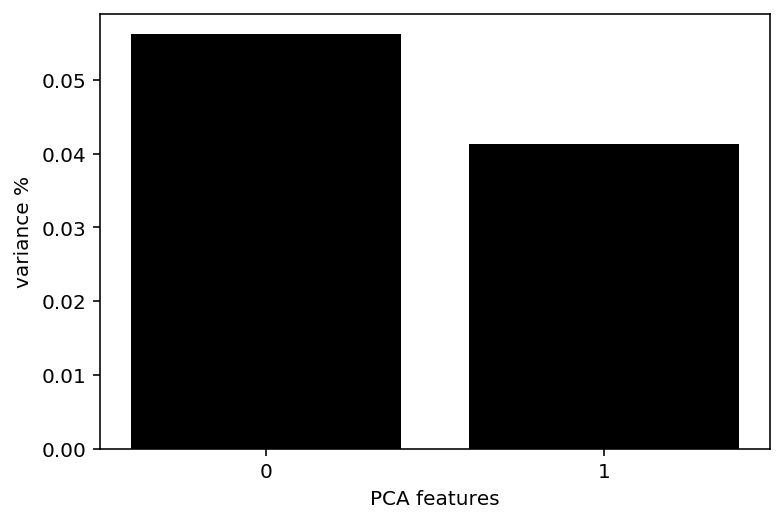

In [205]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [206]:
pca.explained_variance_ratio_

array([0.05617614, 0.04125206])

In [207]:
pd.DataFrame(pca.components_, index = ['PC1','PC2'])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
PC1,0.744269,-0.366804,-0.098892,-0.444831,0.004842,0.021937,0.120888,0.002185,-0.030726,-0.117250,...,-0.096225,-0.167013,-0.045015,0.011966,-0.094221,-0.029740,-0.049431,-0.002688,0.035040,-0.020183
PC2,0.002126,0.721193,-0.277232,-0.395876,-0.147496,0.030077,-0.043727,-0.042234,0.020235,0.010875,...,0.014556,-0.268817,-0.102867,-0.025462,-0.145301,-0.126731,0.031039,0.165809,-0.028261,0.032767


In [208]:
pca.singular_values_

array([167.59495227, 143.61765416])

In [209]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(X_std)

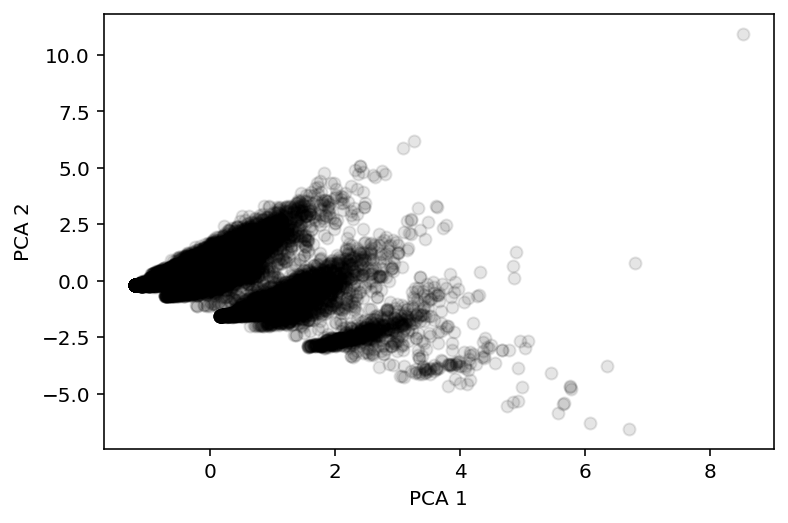

In [210]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.savefig('PCAcomponentsLSA.svg', transparent=True, bbox_inches='tight')

### Kmeans on PCA/LSA

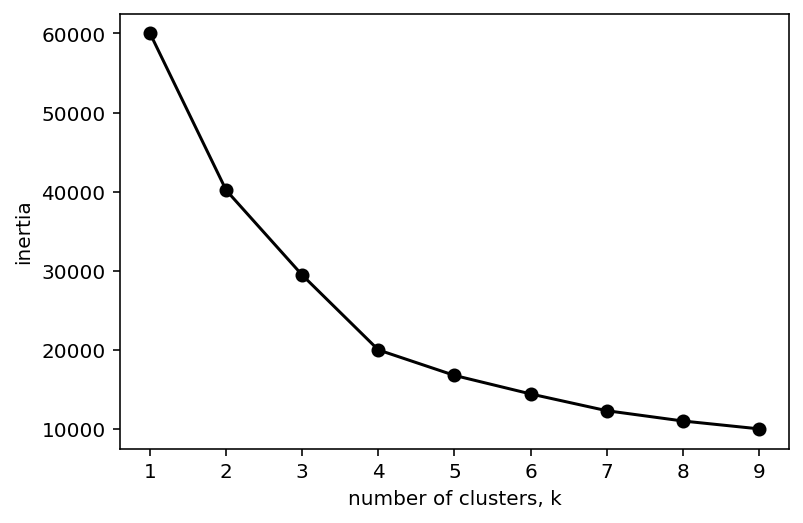

In [211]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig('kmeansonLSA.svg', transparent=True, bbox_inches='tight')
plt.show()


In [212]:
# plt.plot(pca.explained_variance_ratio_)
# plt.xlabel('# components')
# plt.ylabel('explained variance');
# plt.title('Scree plot for PCA on LSA')
# plt.savefig('screepcaLSA.svg', transparent=True, bbox_inches='tight')
# plt.show()

In [213]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('# components')
# plt.ylabel('cumulative explained variance');
# plt.title('Cumulative explained variance by PCA for LSA')
# plt.savefig('pcaforLSA.svg', transparent=True, bbox_inches='tight')
# plt.show()

In [214]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [215]:
num_clusters = 4
km = KMeans(n_clusters=num_clusters)
km.fit(X_std)
clusters = km.labels_.tolist()

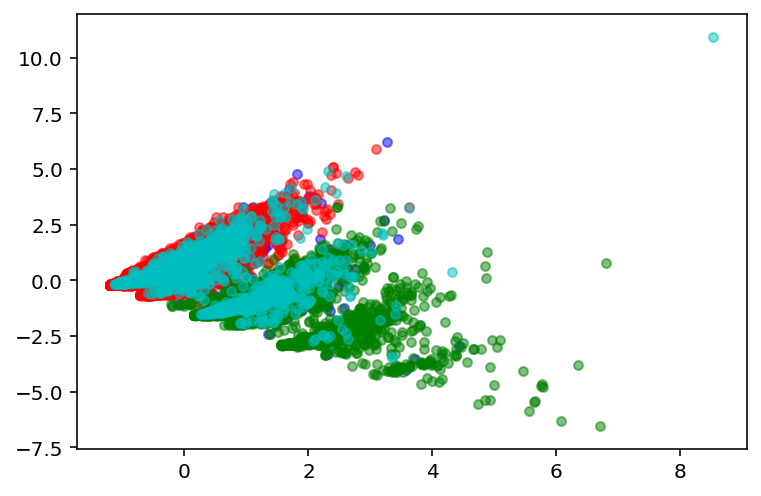

In [216]:
display_cluster(X_std,km,num_clusters)
plt.savefig('lsakmeans', transparent=True, bbox_inches='tight')

### DBSCAN

In [ ]:
# # Standardize our data for DBSCAN and fit DBSCAN
# X = StandardScaler().fit_transform(doc_topic)
# db = DBSCAN(eps=.75, min_samples=100).fit(X)

# # Let's find the observations DBSCAN called "core" - see if core points or not
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

# # Number of clusters in labels, ignoring noise if present. #14 clusters - change radius and get diff # of clusters
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# unique_labels = set(labels)
# colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
# plt.figure(dpi=200)
# show_core = True
# show_non_core = True
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = 'k'

#     class_member_mask = (labels == k)
#     if show_core:
#         xy = X[class_member_mask & core_samples_mask]
#         x, y = xy[:,0], xy[:,1]
#         plt.scatter(x, y, c=col, edgecolors='k',  s=20, linewidths=1.1) # add black border for core points
    
#     if show_non_core:
#         xy = X[class_member_mask & ~core_samples_mask]
#         x, y = xy[:,0], xy[:,1]
#         plt.scatter(x, y, c=col, s=20, linewidths=1.1)

# plt.title('Estimated number of clusters: %d' % n_clusters_);
# plt.savefig('lsadbscan', transparent=True, bbox_inches='tight')

## Non-Negative Matrix Factorization (NMF)

In [217]:
ex_label = [e[:30]+"..." for e in smaller_df.review]

In [218]:
vectorizer = CountVectorizer(stop_words, max_df=.85,ngram_range=(1, 3))
doc_word = vectorizer.fit_transform(smaller_df.review)
pd.DataFrame(doc_word.toarray(), index=ex_label, columns=vectorizer.get_feature_names()).head(10)

,aaaaarg,aaahhh,aaahhh bad,aaahhh bad pain,abandonment,abandonment borderline_personality,abandonment borderline_personality disorder,abate,abate action,abate action fearful,...,zyprexa self,zyprexa self happy,zyprexa symptom,zyprexa symptom tolerable,zypreza,zypreza none,zypreza none different,zyrtec,zyrtec week,zyrtec week severe
daughter school side effect hu...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
week capsule morning night but...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
anxiety depression period awfu...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
night_terror maximum amount pa...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
severe pain hand neck arthriti...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
prescribed medicine pain...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
day second calf pain right leg...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
love scared rubbish oily poo s...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
great...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
product day...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [219]:
nmf_model = NMF(25)#2 topics - hyperparameter - # of topics want
doc_topic2 = nmf_model.fit_transform(doc_word)

In [220]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2", "component_3","component_4","component_5","component_6","component_7","component_8","component_9","component_10",
                     "component_11","component_12","component_13","component_14","component_15","component_16", "component_17","component_18","component_19","component_20",
                     "component_21","component_22","component_23","component_24","component_25"],
             columns = vectorizer.get_feature_names())
topic_word

,aaaaarg,aaahhh,aaahhh bad,aaahhh bad pain,abandonment,abandonment borderline_personality,abandonment borderline_personality disorder,abate,abate action,abate action fearful,...,zyprexa self,zyprexa self happy,zyprexa symptom,zyprexa symptom tolerable,zypreza,zypreza none,zypreza none different,zyrtec,zyrtec week,zyrtec week severe
component_1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.001,...,0.000,0.000,0.001,0.001,0.000,0.000,0.000,0.001,0.001,0.001
component_2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_3,0.000,0.001,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_4,0.000,0.000,0.000,0.000,0.004,0.004,0.004,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.002,0.002,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_7,0.001,0.002,0.002,0.002,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.001,...,0.001,0.001,0.002,0.002,0.000,0.000,0.000,0.000,0.000,0.000
component_9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.001
component_10,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [221]:
terms = display_topics(nmf_model, vectorizer.get_feature_names(), 5)


Topic  0
effect, side, side effect, bad side, bad side effect

Topic  1
period, heavy, light, birth_control, period day

Topic  2
pain, relief, pain pain, back, surgery

Topic  3
anxiety, panic_attack, attack, anxiety depression, disorder

Topic  4
day, period day, day day, couple day, couple

Topic  5
pill, birth_control, birth_control pill, pill pill, pill month

Topic  6
bad, bad side, bad side effect, experience, bad bad

Topic  7
weight, gain, weight gain, pound, loss

Topic  8
month, month month, pound, couple, couple month

Topic  9
night, sleep, morning, sleep night, bed

Topic  10
week, couple, couple week, period week, week week

Topic  11
medicine, effect medicine, good medicine, blood_pressure, side effect medicine

Topic  12
life, happy, quality, quality life, person

Topic  13
good, experience, good thing, way, different

Topic  14
drug, people, miracle, effect drug, miracle drug

Topic  15
skin, clear, face, dry, product

Topic  16
hour, sleep, minute, dose, next

Topic

In [222]:
H = pd.DataFrame(doc_topic2.round(5),
             index = ex_label,
             columns = ["component_1","component_2", "component_3","component_4","component_5","component_6","component_7","component_8","component_9","component_10",
             "component_11","component_12","component_13","component_14","component_15","component_16", "component_17","component_18","component_19","component_20",
            "component_21","component_22","component_23","component_24","component_25"])
H.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_16,component_17,component_18,component_19,component_20,component_21,component_22,component_23,component_24,component_25
daughter school side effect hu...,0.08879,0.00000,0.00000,0.00000,0.00119,0.00006,0.00000,0.00478,0.00002,0.00036,...,0.00000,0.00000,0.00181,0.00000,0.00019,0.00341,0.00000,0.00072,0.00000,0.00000
week capsule morning night but...,0.08666,0.00000,0.40477,0.00000,0.00000,0.00000,0.00000,0.09944,0.00000,0.11789,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.01402,0.00000,0.00325,0.10060,0.00000
anxiety depression period awfu...,0.00000,0.10251,0.00000,0.18384,0.00000,0.00497,0.00125,0.02229,0.00774,0.00000,...,0.12023,0.00000,0.00359,0.00674,0.00000,0.00000,0.00000,0.00165,0.24023,0.01364
night_terror maximum amount pa...,0.00000,0.00000,0.31296,0.00698,0.00049,0.00027,0.00000,0.00126,0.00000,0.06175,...,0.00347,0.01435,0.00381,0.00315,0.00780,0.12423,0.00000,0.00215,0.00527,0.00000
severe pain hand neck arthriti...,0.00000,0.09522,0.20783,0.00265,0.00000,0.10940,0.00000,0.00000,0.00000,0.00017,...,0.00350,0.00619,0.00241,0.00043,0.00000,0.00933,0.15452,0.00425,0.00216,0.00000


### PCA on NMF

In [223]:
pca2 = PCA(n_components=2)
X_std2 = StandardScaler().fit_transform(doc_topic2)
X_transf2 = pca.transform(X_std2)
print("shape of original X_train:", doc_topic2.shape)
print("shape of X_train using 2 principal components:", X_transf2.shape, "\n")
print(X_transf2)

shape of original X_train: (20000, 25)
shape of X_train using 2 principal components: (20000, 2) 

[[ 1.38753894  0.03645323]
 [ 0.70809982 -1.21030393]
 [-2.62121557 -0.73160591]
 ...
 [-0.26703856 -1.71114158]
 [-0.20183613  0.2311084 ]
 [-0.38899135  0.14651907]]


In [224]:
#pca.explained_variance_ratio_

In [225]:
#pd.DataFrame(pca.components_, index = ['PC1','PC2'])

In [226]:
#pca2.singular_values_

In [227]:
pca2.fit(doc_topic2)
principalComponents2 = pca2.transform(doc_topic)

In [228]:
# Save components to a DataFrame
PCA_components2 = pd.DataFrame(principalComponents2)

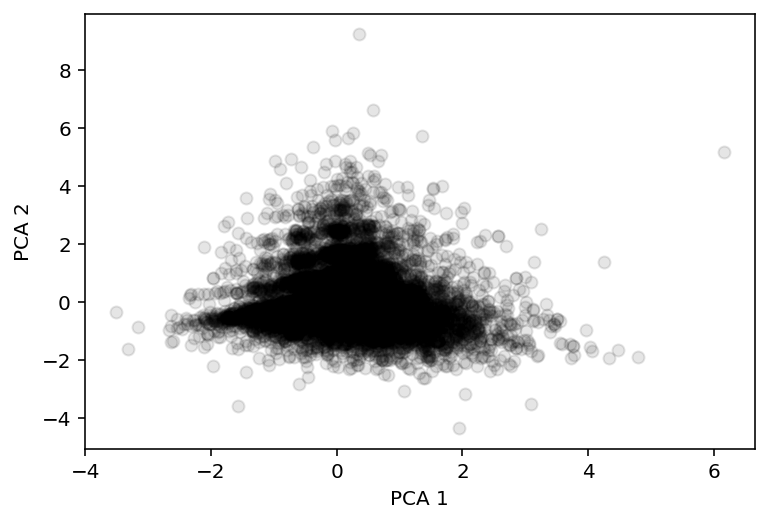

In [229]:
plt.scatter(PCA_components2[0], PCA_components2[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.savefig('PCAcomponentsNMF.svg', transparent=True, bbox_inches='tight')

### K-means on PCA/NMF

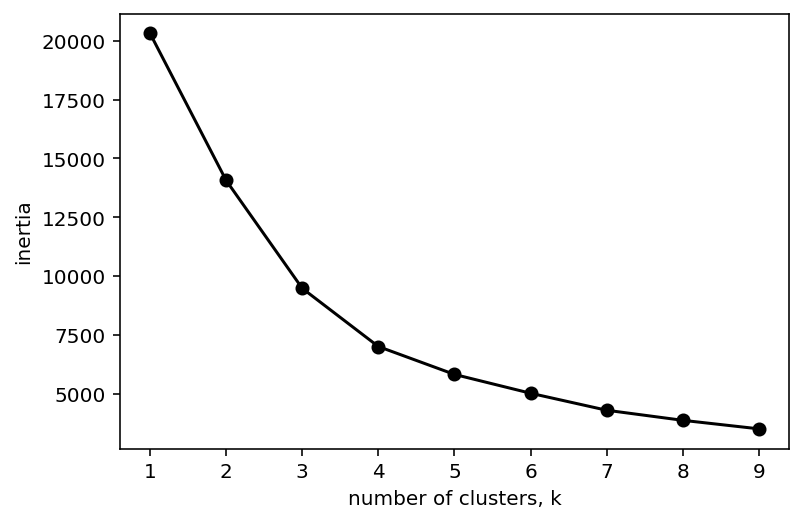

In [230]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components2.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig('kmeansonNMF.svg', transparent=True, bbox_inches='tight')
plt.show()

In [231]:
# plt.plot(pca2.explained_variance_ratio_)
# plt.xlabel('# components')
# plt.ylabel('explained variance');
# plt.title('Scree plot for PCA on LSA')
# plt.savefig('screepcaNMF.svg', transparent=True, bbox_inches='tight')
# plt.show()

In [232]:
# plt.plot(np.cumsum(pca2.explained_variance_ratio_))
# plt.xlabel('# components')
# plt.ylabel('cumulative explained variance');
# plt.title('Cumulative explained variance by PCA for LSA')
# plt.savefig('pcaforNMF.svg', transparent=True, bbox_inches='tight')
# plt.show()

In [233]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [234]:
num_clusters = 2
km = KMeans(n_clusters=num_clusters)
km.fit(X_std2)
clusters = km.labels_.tolist()

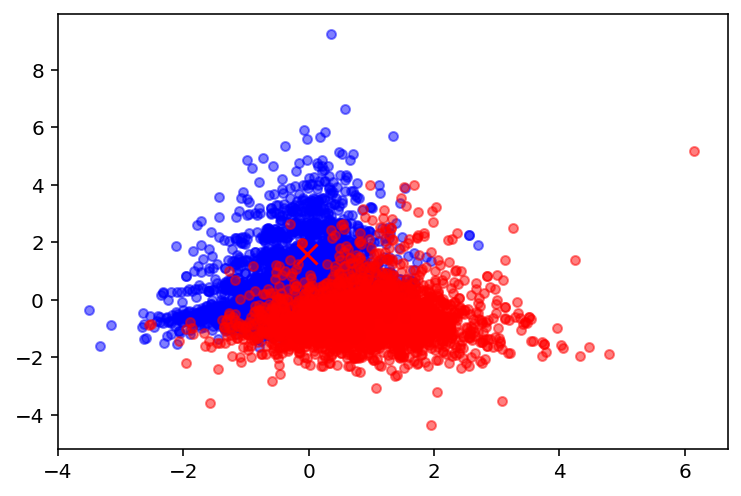

In [235]:
display_cluster(principalComponents2,km,num_clusters)
plt.savefig('nmfkmeans', transparent=True, bbox_inches='tight')

### TSNE

In [ ]:
# time_start = time.time()
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(doc_topic2)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
# tsne_results.shape

### DBSCAN

In [ ]:
# # Standardize our data for DBSCAN and fit DBSCAN
# X = StandardScaler().fit_transform(doc_topic2)
# db = DBSCAN(eps=1, min_samples=75).fit(X)

# # Let's find the observations DBSCAN called "core" - see if core points or not
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

# # Number of clusters in labels, ignoring noise if present. #14 clusters - change radius and get diff # of clusters
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# unique_labels = set(labels)
# colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
# plt.figure(dpi=200)
# show_core = True
# show_non_core = True
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = 'k'

#     class_member_mask = (labels == k)
#     if show_core:
#         xy = X[class_member_mask & core_samples_mask]
#         x, y = xy[:,0], xy[:,1]
#         plt.scatter(x, y, c=col, edgecolors='k',  s=20, linewidths=1.1) # add black border for core points
    
#     if show_non_core:
#         xy = X[class_member_mask & ~core_samples_mask]
#         x, y = xy[:,0], xy[:,1]
#         plt.scatter(x, y, c=col, s=20, linewidths=1.1)

# plt.title('Estimated number of clusters: %d' % n_clusters_);
# plt.savefig('nmfdbscan', transparent=True, bbox_inches='tight')